# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 16      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 124
  d_ff                      : 64
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 2
  num_heads                 : 16
  dropout                   : 0.2

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [5]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')


Processing AAPL (train): 100%|██████████████████| 1066/1066 [00:00<00:00, 22133.64it/s]
[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')


Processing AAPL (val): 100%|██████████████████████| 187/187 [00:00<00:00, 32809.12it/s]


In [6]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [7]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config).to(device)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets_shifted, targets_shifted_targfeat, targets_golden = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets_shifted[0].shape))
    print(targets_shifted[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets_shifted.shape)
    break

summary(model, input_data=(targets_shifted.to(device), targets_shifted_targfeat.to(device)))


6 1
First input sample (shape: torch.Size([5, 6])):
tensor([[0.0176, 0.0160, 0.0144, 0.0153, 0.3030, 0.0000],
        [0.0147, 0.0134, 0.0126, 0.0124, 0.3739, 1.0000],
        [0.0131, 0.0122, 0.0118, 0.0124, 0.3836, 2.0000],
        [0.0137, 0.0129, 0.0138, 0.0138, 0.2193, 3.0000],
        [0.0156, 0.0166, 0.0156, 0.0177, 0.3424, 4.0000]])
Corresponding target (shape: torch.Size([5, 6])):
tensor([[0.0176, 0.0160, 0.0144, 0.0153, 0.3030, 0.0000],
        [0.0176, 0.0160, 0.0144, 0.0153, 0.3030, 0.0000],
        [0.0147, 0.0134, 0.0126, 0.0124, 0.3739, 1.0000],
        [0.0131, 0.0122, 0.0118, 0.0124, 0.3836, 2.0000],
        [0.0137, 0.0129, 0.0138, 0.0138, 0.2193, 3.0000]])
Inputs: torch.Size([16, 5, 6])
Targets: torch.Size([16, 5, 6])
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [16, 5, 1]                1
├─ModuleList: 1-1                             --                        --
│    └─Sequential: 2-1                        [16, 5, 124]              --
│    │    └─Linear: 3-1                       [16, 5, 124]              248
│    │    └─GELU: 3-2                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-3                    [16, 5, 124]              248
│    │    └─Dropout: 3-4                      [16, 5, 124]              --
│    └─Sequential: 2-2                        [16, 5, 124]              --
│    │    └─Linear: 3-5                       [16, 5, 124]              248
│    │    └─GELU: 3-6                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-7                    [16, 5, 124]              248
│    │    └─Dropout: 3-8                      [16, 5, 124]              --
│    └─Sequential

# STEP 3: Setup WandB and Trainer

In [8]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc
wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
# wandb.finish()

In [10]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (1005 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (335 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


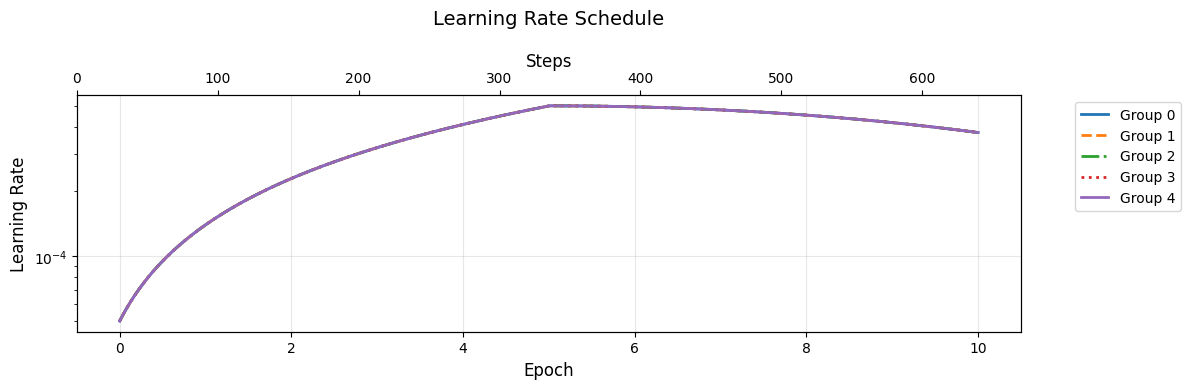

In [11]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
# if trainer.use_wandb:
#     wandb.init(
#         project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
#         config=trainer.config,
#         name=trainer.run_name,
#         settings=wandb.Settings(
#         start_method="thread",             # don't spawn multiprocessing process
#         )
#     )


# Step 4: TRAIN!!   

In [12]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006181513424962759
abm_loss is 0.0036505633033812046


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training:   3%| | 2/67 [00:00<00:14,  4.35it/s, batch_accuracy=3.75%, loss=0.0150, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024182896595448256
abm_loss is 0.005989407189190388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002035587327554822
abm_loss is 0.006192394532263279
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020754216238856316
abm_loss is 0.01055146288126707


Training:  12%| | 8/67 [00:00<00:02, 20.25it/s, batch_accuracy=2.50%, loss=0.0094, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014313719002529979
abm_loss is 0.0052843461744487286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014137098332867026
abm_loss is 0.003720835316926241
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014105228474363685
abm_loss is 0.005800469778478146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012778753880411386
abm_loss is 0.0029433690942823887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016494746087118983
abm_loss is 0.0015386027516797185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015519055305048823
abm_loss is 0.00214012642391

Training:  16%|▏| 11/67 [00:00<00:01, 28.91it/s, batch_accuracy=0.00%, loss=0.0109, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002455338602885604
abm_loss is 0.002328757895156741
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019233577186241746
abm_loss is 0.0015879413112998009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001365622621960938
abm_loss is 0.002349913353100419


Training:  25%|▎| 17/67 [00:00<00:01, 33.98it/s, batch_accuracy=10.00%, loss=0.0273, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014299526810646057
abm_loss is 0.004434770904481411
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001212911680340767
abm_loss is 0.005503037013113499
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011205571936443448
abm_loss is 0.0059398747980594635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014404464745894074
abm_loss is 0.01371415238827467
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00211878283880651
abm_loss is 0.021602092310786247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016758892452344298
abm_loss is 0.028386959806084633


Training:  31%|▎| 21/67 [00:00<00:01, 36.75it/s, batch_accuracy=11.25%, loss=0.0267, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014542952412739396
abm_loss is 0.02286676876246929
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001120069995522499
abm_loss is 0.02731119468808174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013493777951225638
abm_loss is 0.022996803745627403


Training:  39%|▍| 26/67 [00:00<00:01, 39.03it/s, batch_accuracy=20.00%, loss=0.0449, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002783110598102212
abm_loss is 0.03065432421863079
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023164013400673866
abm_loss is 0.031774360686540604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003819165751338005
abm_loss is 0.028514189645648003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0040213242173194885
abm_loss is 0.026929885149002075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019930030684918165
abm_loss is 0.04532189294695854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002038644626736641
abm_loss is 0.048115309327840805


Training:  43%|▍| 29/67 [00:00<00:00, 39.03it/s, batch_accuracy=35.00%, loss=0.0874, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013222231063991785
abm_loss is 0.08587078005075455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010020564077422023
abm_loss is 0.10686180740594864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021664982195943594
abm_loss is 0.055343758314847946


Training:  54%|▌| 36/67 [00:01<00:00, 41.36it/s, batch_accuracy=32.50%, loss=0.0657, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006390234921127558
abm_loss is 0.014416527934372425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00417961785569787
abm_loss is 0.027811065316200256
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001513901399448514
abm_loss is 0.06458763033151627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00188603182323277
abm_loss is 0.05539175868034363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010632205521687865
abm_loss is 0.07834035158157349
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008373514865525067
abm_loss is 0.091709665954113


Training:  57%|▌| 38/67 [00:01<00:00, 41.36it/s, batch_accuracy=10.00%, loss=0.2017, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012994100106880069
abm_loss is 0.14830759167671204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003047710983082652
abm_loss is 0.24185477197170258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0060403537936508656
abm_loss is 0.37031981348991394


Training:  66%|▋| 44/67 [00:01<00:00, 42.13it/s, batch_accuracy=1.25%, loss=0.9939, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003254813840612769
abm_loss is 0.3018634617328644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013035744195804
abm_loss is 0.22026757895946503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026432957965880632
abm_loss is 0.41155967116355896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007729935925453901
abm_loss is 0.6871102452278137
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019317731261253357
abm_loss is 1.1636688709259033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014383581466972828
abm_loss is 1.0803711414337158


Training:  72%|▋| 48/67 [00:01<00:00, 42.47it/s, batch_accuracy=36.25%, loss=0.9209, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011998779140412807
abm_loss is 1.19288170337677
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01672366075217724
abm_loss is 1.5242211818695068
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004864934366196394
abm_loss is 1.1629236936569214


Training:  79%|▊| 53/67 [00:01<00:00, 43.16it/s, batch_accuracy=77.50%, loss=1.2618, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030499007552862167
abm_loss is 1.2739367485046387
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002714974107220769
abm_loss is 1.2051292657852173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005097861867398024
abm_loss is 1.6953678131103516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003593823406845331
abm_loss is 1.7479591369628906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017311664996668696
abm_loss is 1.6254606246948242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008281719870865345
abm_loss is 2.384577512741089


Training:  84%|▊| 56/67 [00:01<00:00, 42.78it/s, batch_accuracy=60.00%, loss=1.6771, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006336045451462269
abm_loss is 2.42156982421875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004577487241476774
abm_loss is 2.145672559738159
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010316628031432629
abm_loss is 1.9055827856063843


Training:  93%|▉| 62/67 [00:01<00:00, 42.94it/s, batch_accuracy=0.00%, loss=1.1457, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030376700684428215
abm_loss is 1.1662122011184692
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02228350192308426
abm_loss is 1.6820240020751953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02971949242055416
abm_loss is 1.5405901670455933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.051759254187345505
abm_loss is 1.1617549657821655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07633981853723526
abm_loss is 0.9903334975242615
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07312658429145813
abm_loss is 1.123565435409546


Training:  99%|▉| 66/67 [00:01<00:00, 43.71it/s, batch_accuracy=11.25%, loss=1.6132, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04294666647911072
abm_loss is 1.4674546718597412
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02635095827281475
abm_loss is 1.9212961196899414
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.011434121057391167
abm_loss is 2.486849546432495


Training: 100%|█| 67/67 [00:01<00:00, 37.73it/s, batch_accuracy=38.00%, loss=1.9745, ma



📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 0.4890 | train_mae: nan | train_accuracy: 16.5854


Training:   4%| | 3/67 [00:00<00:02, 24.66it/s, batch_accuracy=0.00%, loss=0.6772, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12903501093387604
abm_loss is 0.09950339049100876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13624858856201172
abm_loss is 0.09551487863063812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12284701317548752
abm_loss is 0.08054693788290024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  12%| | 8/67 [00:00<00:01, 36.01it/s, batch_accuracy=0.00%, loss=0.2850, mae=

mse_loss is 0.1212502047419548
abm_loss is 0.07964491099119186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09490316361188889
abm_loss is 0.06609919667243958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10328324139118195
abm_loss is 0.08128628879785538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06611937284469604
abm_loss is 0.04544924572110176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05125458166003227
abm_loss is 0.03675840049982071
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04453585669398308
abm_loss is 0.04039151594042778


Training:  16%|▏| 11/67 [00:00<00:01, 36.01it/s, batch_accuracy=0.00%, loss=0.0567, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02865481935441494
abm_loss is 0.020709795877337456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0169063787907362
abm_loss is 0.014088419266045094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010044957511126995
abm_loss is 0.008306539617478848
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  24%|▏| 16/67 [00:00<00:01, 39.25it/s, batch_accuracy=1.25%, loss=0.1059, mae

mse_loss is 0.005561721045523882
abm_loss is 0.004834621679037809
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005156766623258591
abm_loss is 0.008570394478738308
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0049535720609128475
abm_loss is 0.010919220745563507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01068104337900877
abm_loss is 0.022214991971850395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014764063060283661
abm_loss is 0.041505347937345505
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019286667928099632
abm_loss is 0.05945950746536255


Training:  28%|▎| 19/67 [00:00<00:01, 40.56it/s, batch_accuracy=3.75%, loss=0.1291, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02400432527065277
abm_loss is 0.07842081785202026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016685863956809044
abm_loss is 0.05914567783474922
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014224546030163765
abm_loss is 0.06737063080072403


Training:  37%|▎| 25/67 [00:00<00:01, 41.21it/s, batch_accuracy=17.50%, loss=0.0552, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015160036273300648
abm_loss is 0.0670064315199852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009701631031930447
abm_loss is 0.06814204156398773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009261025115847588
abm_loss is 0.06999463587999344
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005408225115388632
abm_loss is 0.05258655548095703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003821631660684943
abm_loss is 0.046827077865600586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004808241035789251
abm_loss is 0.04801587760448456


Training:  42%|▍| 28/67 [00:00<00:00, 42.10it/s, batch_accuracy=6.25%, loss=0.0904, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007520617451518774
abm_loss is 0.04921844229102135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0062768468633294106
abm_loss is 0.07655846327543259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007084517274051905
abm_loss is 0.0869395062327385


Training:  51%|▌| 34/67 [00:00<00:00, 42.14it/s, batch_accuracy=0.00%, loss=0.1178, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009856111370027065
abm_loss is 0.04157675430178642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021647481247782707
abm_loss is 0.011585221625864506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020871136337518692
abm_loss is 0.020073069259524345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017188794910907745
abm_loss is 0.04132887348532677
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01870892196893692
abm_loss is 0.03126324340701103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015173517167568207
abm_loss is 0.04383820667862892


Training:  57%|▌| 38/67 [00:00<00:00, 42.87it/s, batch_accuracy=2.50%, loss=0.1234, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009842497296631336
abm_loss is 0.06070813164114952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010506780818104744
abm_loss is 0.09181828796863556
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004772999323904514
abm_loss is 0.18152374029159546


Training:  64%|▋| 43/67 [00:01<00:00, 42.61it/s, batch_accuracy=23.75%, loss=0.5326, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023380154743790627
abm_loss is 0.2946937084197998
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005019246134907007
abm_loss is 0.26529034972190857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004087419249117374
abm_loss is 0.1961604207754135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037217491772025824
abm_loss is 0.3938504159450531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007187554147094488
abm_loss is 0.6442129015922546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016450287774205208
abm_loss is 1.1346596479415894


Training:  69%|▋| 46/67 [00:01<00:00, 42.61it/s, batch_accuracy=21.25%, loss=0.9603, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012139926664531231
abm_loss is 1.0226566791534424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012238468043506145
abm_loss is 1.166144609451294
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014775916002690792
abm_loss is 1.4581822156906128


Training:  79%|▊| 53/67 [00:01<00:00, 42.79it/s, batch_accuracy=50.00%, loss=1.2485, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008434058167040348
abm_loss is 1.1470774412155151
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005855030380189419
abm_loss is 1.228658676147461
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00634431978687644
abm_loss is 1.1134943962097168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004849945195019245
abm_loss is 1.556653618812561
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005701967980712652
abm_loss is 1.5824154615402222
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012105636298656464
abm_loss is 1.447182059288025


Training:  82%|▊| 55/67 [00:01<00:00, 42.79it/s, batch_accuracy=53.75%, loss=1.7353, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004342007916420698
abm_loss is 2.138502836227417
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005490181501954794
abm_loss is 2.21514892578125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012290912680327892
abm_loss is 1.9369395971298218


Training:  91%|▉| 61/67 [00:01<00:00, 42.89it/s, batch_accuracy=0.00%, loss=1.2175, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02458111196756363
abm_loss is 1.7085784673690796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061524905264377594
abm_loss is 1.0538153648376465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035104066133499146
abm_loss is 1.615801215171814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04532616212964058
abm_loss is 1.4445914030075073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06854667514562607
abm_loss is 1.1340839862823486
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09178932756185532
abm_loss is 0.9461174011230469


Training:  96%|▉| 64/67 [00:01<00:00, 42.66it/s, batch_accuracy=0.00%, loss=1.3553, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06515654176473618
abm_loss is 1.1314398050308228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040718354284763336
abm_loss is 1.4935544729232788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02059548906981945
abm_loss is 1.9875459671020508


Training: 100%|█| 67/67 [00:01<00:00, 41.02it/s, batch_accuracy=32.00%, loss=1.9549, ma


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.009766747243702412
abm_loss is 2.4722108840942383

📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 0.5678 | train_mae: nan | train_accuracy: 12.4765


Training:   1%| | 1/67 [00:00<00:06, 10.42it/s, batch_accuracy=2.50%, loss=0.0301, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00547208683565259
abm_loss is 0.013673004694283009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003696199506521225
abm_loss is 0.014974074438214302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020174782257527113
abm_loss is 0.011712776497006416


Training:  12%| | 8/67 [00:00<00:01, 35.00it/s, batch_accuracy=1.25%, loss=0.0946, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021625699009746313
abm_loss is 0.00838084239512682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005185974296182394
abm_loss is 0.004356435965746641
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007818709127604961
abm_loss is 0.0037144122179597616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013956861570477486
abm_loss is 0.006782280746847391
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017309846356511116
abm_loss is 0.010235431604087353
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02590077556669712
abm_loss is 0.022606411948800087


Training:  15%|▏| 10/67 [00:00<00:01, 35.00it/s, batch_accuracy=0.00%, loss=0.1786, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03180781006813049
abm_loss is 0.023906076326966286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0315374881029129
abm_loss is 0.026795143261551857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028339112177491188
abm_loss is 0.02457510307431221


Training:  24%|▏| 16/67 [00:00<00:01, 38.45it/s, batch_accuracy=0.00%, loss=0.0797, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029291976243257523
abm_loss is 0.020636677742004395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023475876078009605
abm_loss is 0.014131814241409302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02654828503727913
abm_loss is 0.01543895062059164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017588993534445763
abm_loss is 0.008793652057647705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015019583515822887
abm_loss is 0.0058834971860051155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010730505920946598
abm_loss is 0.0074461656622588634


Training:  28%|▎| 19/67 [00:00<00:01, 40.63it/s, batch_accuracy=5.00%, loss=0.0371, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005585222039371729
abm_loss is 0.013850303366780281
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005446379538625479
abm_loss is 0.012784965336322784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002720271237194538
abm_loss is 0.02247331105172634


Training:  37%|▎| 25/67 [00:00<00:01, 41.33it/s, batch_accuracy=20.00%, loss=0.0458, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004580636974424124
abm_loss is 0.028703439980745316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002874671248719096
abm_loss is 0.04297913610935211
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00399785814806819
abm_loss is 0.04923568293452263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002796054817736149
abm_loss is 0.03771805390715599
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028935379814356565
abm_loss is 0.04066236689686775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003393795806914568
abm_loss is 0.05444982647895813


Training:  42%|▍| 28/67 [00:00<00:00, 41.81it/s, batch_accuracy=18.75%, loss=0.0953, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026182772126048803
abm_loss is 0.060841917991638184
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034599360078573227
abm_loss is 0.10119032859802246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004655127879232168
abm_loss is 0.11368141323328018


Training:  51%|▌| 34/67 [00:00<00:00, 42.60it/s, batch_accuracy=1.25%, loss=0.0995, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00550425797700882
abm_loss is 0.059079140424728394
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008784537203609943
abm_loss is 0.013974234461784363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010740120895206928
abm_loss is 0.027659395709633827
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012031088583171368
abm_loss is 0.04448143392801285
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014611474238336086
abm_loss is 0.0341208390891552
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010261180810630322
abm_loss is 0.049338776618242264


Training:  57%|▌| 38/67 [00:00<00:00, 42.59it/s, batch_accuracy=16.25%, loss=0.1172, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008232652209699154
abm_loss is 0.06543736159801483
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008373696357011795
abm_loss is 0.0976426750421524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007836493663489819
abm_loss is 0.16290222108364105


Training:  64%|▋| 43/67 [00:01<00:00, 42.53it/s, batch_accuracy=40.00%, loss=0.4556, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003976810723543167
abm_loss is 0.28538939356803894
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006171983666718006
abm_loss is 0.2293548583984375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0057891253381967545
abm_loss is 0.17715592682361603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003626968013122678
abm_loss is 0.3496241271495819
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033776394557207823
abm_loss is 0.5689837336540222
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005164250731468201
abm_loss is 0.9857267737388611


Training:  69%|▋| 46/67 [00:01<00:00, 42.53it/s, batch_accuracy=42.50%, loss=0.7818, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004630696959793568
abm_loss is 0.8712494969367981
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00502976356074214
abm_loss is 0.9814453125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004277758300304413
abm_loss is 1.2111577987670898


Training:  79%|▊| 53/67 [00:01<00:00, 42.97it/s, batch_accuracy=18.75%, loss=1.1924, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012793037109076977
abm_loss is 0.9139375686645508
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013935479335486889
abm_loss is 1.0252900123596191
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02524166740477085
abm_loss is 0.9424633383750916
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012512308545410633
abm_loss is 1.3748468160629272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016548454761505127
abm_loss is 1.4391732215881348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02061580680310726
abm_loss is 1.3552148342132568


Training:  82%|▊| 55/67 [00:01<00:00, 42.97it/s, batch_accuracy=41.25%, loss=1.6910, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008683452382683754
abm_loss is 2.0436336994171143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00902651622891426
abm_loss is 2.1348178386688232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018278425559401512
abm_loss is 1.8961890935897827


Training:  91%|▉| 61/67 [00:01<00:00, 42.74it/s, batch_accuracy=1.25%, loss=1.2031, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024103296920657158
abm_loss is 1.6967626810073853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.055874597281217575
abm_loss is 1.0678752660751343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03322875499725342
abm_loss is 1.5896371603012085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04142904281616211
abm_loss is 1.4910086393356323
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0646209865808487
abm_loss is 1.1408560276031494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06768079102039337
abm_loss is 1.023958444595337


Training:  96%|▉| 64/67 [00:01<00:00, 43.31it/s, batch_accuracy=3.75%, loss=1.3342, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.060799188911914825
abm_loss is 1.1511536836624146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03531442955136299
abm_loss is 1.5012892484664917
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01699361763894558
abm_loss is 2.00938081741333


Training: 100%|█| 67/67 [00:01<00:00, 41.02it/s, batch_accuracy=58.00%, loss=2.0067, ma


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.007483288645744324
abm_loss is 2.5542092323303223

📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 0.4746 | train_mae: nan | train_accuracy: 13.3959


Training:  12%| | 8/67 [00:00<00:01, 35.23it/s, batch_accuracy=1.25%, loss=0.0273, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05913181230425835
abm_loss is 0.08295444399118423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.056804634630680084
abm_loss is 0.09374918788671494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.051651980727910995
abm_loss is 0.08848398178815842
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03981730341911316
abm_loss is 0.07142739742994308
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027274107560515404
abm_loss is 0.04803045839071274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014669427648186684
abm_loss is 0.02584248222410679
shape of tgt

Training:  24%|▏| 16/67 [00:00<00:01, 38.68it/s, batch_accuracy=0.00%, loss=0.0688, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011240782914683223
abm_loss is 0.0022167463321238756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028245921712368727
abm_loss is 0.0020734958816319704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006036368664354086
abm_loss is 0.004434407223016024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007187688257545233
abm_loss is 0.0044803800992667675
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011010607704520226
abm_loss is 0.005293911322951317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011019126512110233
abm_loss is 0.00503626698628068


Training:  37%|▎| 25/67 [00:00<00:01, 41.16it/s, batch_accuracy=3.75%, loss=0.0658, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010907170362770557
abm_loss is 0.008871195837855339
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013204114511609077
abm_loss is 0.007592897862195969
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010981269180774689
abm_loss is 0.013086619786918163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016602162271738052
abm_loss is 0.01020708680152893
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010333946906030178
abm_loss is 0.018150324001908302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011859849095344543
abm_loss is 0.0192694291472435
shape o

Training:  51%|▌| 34/67 [00:00<00:00, 42.62it/s, batch_accuracy=8.75%, loss=0.0592, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007290968205779791
abm_loss is 0.03699051961302757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034686760045588017
abm_loss is 0.07575985789299011
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003956221044063568
abm_loss is 0.08677524328231812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005030385218560696
abm_loss is 0.045493170619010925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008213064633309841
abm_loss is 0.012851761654019356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007231207098811865
abm_loss is 0.027501685544848442
shape 

Training:  64%|▋| 43/67 [00:01<00:00, 42.87it/s, batch_accuracy=42.50%, loss=0.4345, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029544306453317404
abm_loss is 0.07969624549150467
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002836530329659581
abm_loss is 0.11939860880374908
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026822916697710752
abm_loss is 0.1813877522945404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024249334819614887
abm_loss is 0.29395636916160583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034757547546178102
abm_loss is 0.25893434882164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005253840237855911
abm_loss is 0.17704594135284424
shape of t

Training:  79%|▊| 53/67 [00:01<00:00, 42.99it/s, batch_accuracy=17.50%, loss=1.1884, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005033693742007017
abm_loss is 0.8243706822395325
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006050830241292715
abm_loss is 0.9462278485298157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006858748383820057
abm_loss is 1.1839128732681274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01905072294175625
abm_loss is 0.8874517679214478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014552679844200611
abm_loss is 1.0303583145141602
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021101798862218857
abm_loss is 0.9405205845832825
shape of tgt_comb

Training:  91%|▉| 61/67 [00:01<00:00, 43.01it/s, batch_accuracy=2.50%, loss=1.1858, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005948336329311132
abm_loss is 2.1309895515441895
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007209069561213255
abm_loss is 2.1704113483428955
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012570845894515514
abm_loss is 1.9620414972305298
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019527291879057884
abm_loss is 1.757646918296814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04708056524395943
abm_loss is 1.1194406747817993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026448404416441917
abm_loss is 1.6498726606369019
shape of tgt_combi

Training: 100%|█| 67/67 [00:01<00:00, 41.09it/s, batch_accuracy=64.00%, loss=1.9859, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0506783090531826
abm_loss is 1.1821832656860352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033695559948682785
abm_loss is 1.5293954610824585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012908185832202435
abm_loss is 2.061843156814575
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0046760886907577515
abm_loss is 2.5454843044281006

📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 0.4799 | train_mae: nan | train_accuracy: 12.1576


Training:  12%| | 8/67 [00:00<00:01, 35.69it/s, batch_accuracy=1.25%, loss=0.0138, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023617432452738285
abm_loss is 0.009182441048324108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003519009565934539
abm_loss is 0.01675182208418846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034454420674592257
abm_loss is 0.016776351258158684
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00394120067358017
abm_loss is 0.018107034265995026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003058990463614464
abm_loss is 0.012502309866249561
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022031248081475496
abm_loss is 0.006746046245098114
sha

Training:  24%|▏| 16/67 [00:00<00:01, 38.54it/s, batch_accuracy=5.00%, loss=0.0135, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014158805133774877
abm_loss is 0.0029063087422400713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012563748750835657
abm_loss is 0.001887915306724608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016560525400564075
abm_loss is 0.0016998205101117492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011924862628802657
abm_loss is 0.002020972315222025
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013152697356417775
abm_loss is 0.00265531986951828
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010672592325136065
abm_loss is 0.0024146668147295

Training:  37%|▎| 25/67 [00:00<00:01, 41.53it/s, batch_accuracy=1.25%, loss=0.0618, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013680446427315474
abm_loss is 0.018291888758540154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001989288255572319
abm_loss is 0.015353317372500896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021019112318754196
abm_loss is 0.021933382377028465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002930958056822419
abm_loss is 0.017842059955000877
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032992386259138584
abm_loss is 0.025084609165787697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003936334513127804
abm_loss is 0.02727973461151123
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.26it/s, batch_accuracy=7.50%, loss=0.0600, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012296688742935658
abm_loss is 0.02987389825284481
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009815561585128307
abm_loss is 0.05692937970161438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008976754732429981
abm_loss is 0.0710425153374672
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009438599459826946
abm_loss is 0.03735392913222313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012437776662409306
abm_loss is 0.010857631452381611
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00948979239910841
abm_loss is 0.023222800344228745
shape of t

Training:  64%|▋| 43/67 [00:01<00:00, 42.25it/s, batch_accuracy=25.00%, loss=0.4173, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026757733430713415
abm_loss is 0.07802583277225494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016548580024391413
abm_loss is 0.12234270572662354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002201235620304942
abm_loss is 0.20003946125507355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015567336231470108
abm_loss is 0.30383819341659546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031061340123414993
abm_loss is 0.24887223541736603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037899718154221773
abm_loss is 0.18020504713058472
shape

Training:  79%|▊| 53/67 [00:01<00:00, 43.05it/s, batch_accuracy=18.75%, loss=1.1873, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008944530971348286
abm_loss is 0.773138165473938
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014757893048226833
abm_loss is 0.8535682559013367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014759532175958157
abm_loss is 1.1090459823608398
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02690744958817959
abm_loss is 0.8451957702636719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025560755282640457
abm_loss is 0.9563731551170349
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039210665971040726
abm_loss is 0.8582682609558105
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 42.50it/s, batch_accuracy=2.50%, loss=1.1604, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00846843235194683
abm_loss is 2.027923822402954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007968301884829998
abm_loss is 2.131453275680542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011764359660446644
abm_loss is 1.9518709182739258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022089412435889244
abm_loss is 1.7122554779052734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04568064585328102
abm_loss is 1.1188539266586304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025519927963614464
abm_loss is 1.6597797870635986
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.02it/s, batch_accuracy=54.00%, loss=1.9838, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048650529235601425
abm_loss is 1.1954883337020874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03576505184173584
abm_loss is 1.5233415365219116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010609850287437439
abm_loss is 2.1018025875091553
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.00559085002169013
abm_loss is 2.5367937088012695

📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 0.4471 | train_mae: nan | train_accuracy: 11.6698


Training:  10%| | 7/67 [00:00<00:01, 34.91it/s, batch_accuracy=7.50%, loss=0.0069, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008461225661449134
abm_loss is 0.00315173645503819
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008255658904090524
abm_loss is 0.0077037750743329525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00098046928178519
abm_loss is 0.008506488986313343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010529725113883615
abm_loss is 0.011055759154260159
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009194318554364145
abm_loss is 0.006489264313131571
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007765211630612612
abm_loss is 0.003531503025442362


Training:  25%|▎| 17/67 [00:00<00:01, 40.00it/s, batch_accuracy=5.00%, loss=0.0188, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008599666762165725
abm_loss is 0.0021930686198174953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011235021520406008
abm_loss is 0.001587518723681569
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012011926155537367
abm_loss is 0.0011720198672264814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009435914689674973
abm_loss is 0.0023944221902638674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001085286377929151
abm_loss is 0.0045508891344070435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000932709313929081
abm_loss is 0.004374815616756

Training:  37%|▎| 25/67 [00:00<00:01, 41.68it/s, batch_accuracy=20.00%, loss=0.0361, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001550910179503262
abm_loss is 0.030374659225344658
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018476992845535278
abm_loss is 0.026968693360686302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001988175557926297
abm_loss is 0.03773963823914528
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018232468282803893
abm_loss is 0.03500128164887428
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012995230499655008
abm_loss is 0.04476736858487129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016506994143128395
abm_loss is 0.05135302618145943
shap

Training:  51%|▌| 34/67 [00:00<00:00, 42.12it/s, batch_accuracy=2.50%, loss=0.0870, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011511596385389566
abm_loss is 0.05720801278948784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007111342856660485
abm_loss is 0.0887652263045311
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019538982305675745
abm_loss is 0.09432580322027206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003650904865935445
abm_loss is 0.046770501881837845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009499096311628819
abm_loss is 0.01262405700981617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010503821074962616
abm_loss is 0.02253636159002781
shape o

Training:  64%|▋| 43/67 [00:01<00:00, 43.04it/s, batch_accuracy=38.75%, loss=0.4500, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01230651792138815
abm_loss is 0.047932833433151245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008784490637481213
abm_loss is 0.08236074447631836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0062380894087255
abm_loss is 0.15663638710975647
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006880450993776321
abm_loss is 0.23786531388759613
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0072640287689864635
abm_loss is 0.21425198018550873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005786872934550047
abm_loss is 0.16725067794322968
shape of tg

Training:  78%|▊| 52/67 [00:01<00:00, 43.20it/s, batch_accuracy=11.25%, loss=1.1789, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007333351764827967
abm_loss is 0.7974831461906433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008054076693952084
abm_loss is 0.9060806632041931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00878813024610281
abm_loss is 1.149112343788147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021168813109397888
abm_loss is 0.86970055103302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021543165668845177
abm_loss is 0.9626837968826294
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025399405509233475
abm_loss is 0.9226507544517517
shape of tgt_combine

Training:  93%|▉| 62/67 [00:01<00:00, 42.68it/s, batch_accuracy=1.25%, loss=1.1510, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011907726526260376
abm_loss is 1.9656238555908203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011369912885129452
abm_loss is 2.0789144039154053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01545406598597765
abm_loss is 1.8950719833374023
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02580234408378601
abm_loss is 1.7162383794784546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05586196109652519
abm_loss is 1.079962134361267
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029486283659934998
abm_loss is 1.6251038312911987
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.08it/s, batch_accuracy=58.00%, loss=1.9973, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.051507025957107544
abm_loss is 1.200283408164978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029979124665260315
abm_loss is 1.564239740371704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012232695706188679
abm_loss is 2.0159270763397217
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.006794517859816551
abm_loss is 2.5465023517608643

📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 0.4416 | train_mae: nan | train_accuracy: 12.1388


Training:  12%| | 8/67 [00:00<00:01, 35.09it/s, batch_accuracy=2.50%, loss=0.0089, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005259239114820957
abm_loss is 0.0028607745189219713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033984375186264515
abm_loss is 0.002368532121181488
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003194520017132163
abm_loss is 0.0036084100138396025
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001658150926232338
abm_loss is 0.003776604076847434
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023256237618625164
abm_loss is 0.002948277397081256
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026494350749999285
abm_loss is 0.001458713435567915

Training:  24%|▏| 16/67 [00:00<00:01, 38.79it/s, batch_accuracy=10.00%, loss=0.0179, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001065449439920485
abm_loss is 0.000956217001657933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011587238404899836
abm_loss is 0.0009904232574626803
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011930955806747079
abm_loss is 0.0008993590599857271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008583394810557365
abm_loss is 0.0012365877628326416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005765866371802986
abm_loss is 0.0024501197040081024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006426620529964566
abm_loss is 0.00391580164432

Training:  37%|▎| 25/67 [00:00<00:01, 41.27it/s, batch_accuracy=38.75%, loss=0.0378, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021423688158392906
abm_loss is 0.03282888978719711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019735523965209723
abm_loss is 0.030184051021933556
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021901659201830626
abm_loss is 0.0405387356877327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018858518451452255
abm_loss is 0.039533473551273346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002159526338800788
abm_loss is 0.052193861454725266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011082281125709414
abm_loss is 0.05065426975488663
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.87it/s, batch_accuracy=1.25%, loss=0.0854, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006163911311887205
abm_loss is 0.056116461753845215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006234855391085148
abm_loss is 0.09259133785963058
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010359640000388026
abm_loss is 0.10002396255731583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004354687407612801
abm_loss is 0.04440515860915184
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009060606360435486
abm_loss is 0.011006553657352924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00849876832216978
abm_loss is 0.02333487756550312
shape 

Training:  64%|▋| 43/67 [00:01<00:00, 43.10it/s, batch_accuracy=36.25%, loss=0.4328, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010472678579390049
abm_loss is 0.050260867923498154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009566828608512878
abm_loss is 0.08428240567445755
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006185248959809542
abm_loss is 0.1516282707452774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004767460282891989
abm_loss is 0.25973451137542725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008686963468790054
abm_loss is 0.2203218936920166
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003915728535503149
abm_loss is 0.17934563755989075
shape of tg

Training:  79%|▊| 53/67 [00:01<00:00, 42.67it/s, batch_accuracy=10.00%, loss=1.1855, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008987284265458584
abm_loss is 0.7614732980728149
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008434134535491467
abm_loss is 0.9189643263816833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012246250174939632
abm_loss is 1.1011430025100708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019769666716456413
abm_loss is 0.8795813918113708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02534695900976658
abm_loss is 0.9317613840103149
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02475847117602825
abm_loss is 0.9208409190177917
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.30it/s, batch_accuracy=0.00%, loss=1.1577, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01376501377671957
abm_loss is 1.9875534772872925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01078034844249487
abm_loss is 2.1153624057769775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015077951364219189
abm_loss is 1.8903875350952148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0237934160977602
abm_loss is 1.6925067901611328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05476120859384537
abm_loss is 1.0631895065307617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02819696068763733
abm_loss is 1.639888048171997
shape of tgt_combined: 

Training: 100%|█| 67/67 [00:01<00:00, 41.15it/s, batch_accuracy=70.00%, loss=1.9792, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04676206782460213
abm_loss is 1.1841779947280884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027228767052292824
abm_loss is 1.5450676679611206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012884053401648998
abm_loss is 2.0547444820404053
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.003958676476031542
abm_loss is 2.5415337085723877

📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 0.4420 | train_mae: nan | train_accuracy: 12.4203


Training:  12%| | 8/67 [00:00<00:01, 35.72it/s, batch_accuracy=0.00%, loss=0.0080, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016487408429384232
abm_loss is 0.00238634180277586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006596320308744907
abm_loss is 0.005341035779565573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007544446270912886
abm_loss is 0.005740008316934109
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005258893361315131
abm_loss is 0.0056826043874025345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010815559653565288
abm_loss is 0.0034030613023787737
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011389761930331588
abm_loss is 0.0012735087657347

Training:  24%|▏| 16/67 [00:00<00:01, 38.75it/s, batch_accuracy=5.00%, loss=0.0131, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010779387084767222
abm_loss is 0.000945042644161731
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00125585263594985
abm_loss is 0.0010773282265290618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011965164449065924
abm_loss is 0.0007574381306767464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006742192781530321
abm_loss is 0.001115931081585586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005961140850558877
abm_loss is 0.0030831731855869293
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048247529775835574
abm_loss is 0.003296526847407

Training:  37%|▎| 25/67 [00:00<00:00, 42.19it/s, batch_accuracy=23.75%, loss=0.0388, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012101114261895418
abm_loss is 0.028920158743858337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009123724303208292
abm_loss is 0.024864962324500084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010158199584111571
abm_loss is 0.034961313009262085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009943190962076187
abm_loss is 0.034477945417165756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013465164229273796
abm_loss is 0.047148361802101135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001294683082960546
abm_loss is 0.05502544716000557


Training:  51%|▌| 34/67 [00:00<00:00, 42.87it/s, batch_accuracy=0.00%, loss=0.0622, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003655653854366392
abm_loss is 0.06035802885890007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007990733720362186
abm_loss is 0.10233085602521896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006526144570671022
abm_loss is 0.11116504669189453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015117187285795808
abm_loss is 0.05451641231775284
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0061081405729055405
abm_loss is 0.014180122874677181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005530148278921843
abm_loss is 0.026263562962412834
sha

Training:  64%|▋| 43/67 [00:01<00:00, 43.33it/s, batch_accuracy=25.00%, loss=0.4041, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007331082131713629
abm_loss is 0.05926410108804703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007202693726867437
abm_loss is 0.09164204448461533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006816269364207983
abm_loss is 0.14642086625099182
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004797197878360748
abm_loss is 0.24702005088329315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00949135422706604
abm_loss is 0.2004578560590744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007888504303991795
abm_loss is 0.1672922968864441
shape of tgt_

Training:  79%|▊| 53/67 [00:01<00:00, 43.41it/s, batch_accuracy=8.75%, loss=1.1753, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008518965914845467
abm_loss is 0.7591041922569275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010709067806601524
abm_loss is 0.8817983865737915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009740724228322506
abm_loss is 1.1292880773544312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02680378593504429
abm_loss is 0.827073872089386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021335436031222343
abm_loss is 0.9726645350456238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025656556710600853
abm_loss is 0.9154236912727356
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.51it/s, batch_accuracy=1.25%, loss=1.1839, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008461667224764824
abm_loss is 2.0209712982177734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013546186499297619
abm_loss is 2.050971746444702
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011585823260247707
abm_loss is 1.9172579050064087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02426583133637905
abm_loss is 1.6785598993301392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04968922957777977
abm_loss is 1.0772455930709839
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03322692587971687
abm_loss is 1.5684103965759277
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.41it/s, batch_accuracy=60.00%, loss=2.0074, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04973086714744568
abm_loss is 1.1806738376617432
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031139973551034927
abm_loss is 1.5528472661972046
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01090856920927763
abm_loss is 2.054042100906372
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.006124143488705158
abm_loss is 2.5639491081237793

📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 0.4371 | train_mae: nan | train_accuracy: 12.5516


Training:  12%| | 8/67 [00:00<00:01, 34.53it/s, batch_accuracy=3.75%, loss=0.0070, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001529379514977336
abm_loss is 0.0021408312022686005
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012276432244107127
abm_loss is 0.00413967901840806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001046875142492354
abm_loss is 0.004180858377367258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008918527746573091
abm_loss is 0.0044549014419317245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014293796848505735
abm_loss is 0.0029875654727220535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018150912364944816
abm_loss is 0.00136330723762512

Training:  24%|▏| 16/67 [00:00<00:01, 39.09it/s, batch_accuracy=8.75%, loss=0.0115, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012681143125519156
abm_loss is 0.0006440621218644083
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016785163898020983
abm_loss is 0.0013316237600520253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011818427592515945
abm_loss is 0.0006768435705453157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007545641856268048
abm_loss is 0.0010908158728852868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005175367114134133
abm_loss is 0.0025468722451478243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005358974449336529
abm_loss is 0.002515024272

Training:  37%|▎| 25/67 [00:00<00:01, 41.42it/s, batch_accuracy=26.25%, loss=0.0372, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013061667559668422
abm_loss is 0.030669767409563065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001158647588454187
abm_loss is 0.027881721034646034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013081446522846818
abm_loss is 0.036669161170721054
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000795283354818821
abm_loss is 0.03391006588935852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013679160038009286
abm_loss is 0.04848770052194595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001385882613249123
abm_loss is 0.053528595715761185
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.54it/s, batch_accuracy=2.50%, loss=0.0585, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045628310181200504
abm_loss is 0.06372501701116562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006349175237119198
abm_loss is 0.10181813687086105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006048919749446213
abm_loss is 0.11333747953176498
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012753725750371814
abm_loss is 0.05840543657541275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004959021229296923
abm_loss is 0.014758050441741943
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004240203183144331
abm_loss is 0.02837025560438633
shap

Training:  64%|▋| 43/67 [00:01<00:00, 42.79it/s, batch_accuracy=31.25%, loss=0.4208, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0055355955846607685
abm_loss is 0.06106233596801758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004560327623039484
abm_loss is 0.09792646020650864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037357464898377657
abm_loss is 0.16102342307567596
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005171728786081076
abm_loss is 0.24388627707958221
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006725537125021219
abm_loss is 0.20994392037391663
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008427172899246216
abm_loss is 0.15677310526371002
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 42.83it/s, batch_accuracy=8.75%, loss=1.1660, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012497983872890472
abm_loss is 0.7337350249290466
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015535893850028515
abm_loss is 0.8335879445075989
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013145473785698414
abm_loss is 1.0703580379486084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020337870344519615
abm_loss is 0.8680692911148071
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023711515590548515
abm_loss is 0.9428316354751587
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02900250069797039
abm_loss is 0.885869026184082
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.10it/s, batch_accuracy=0.00%, loss=1.1461, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009073623456060886
abm_loss is 2.0242741107940674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008136403746902943
abm_loss is 2.1117875576019287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012752550654113293
abm_loss is 1.931104302406311
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022542094811797142
abm_loss is 1.7289276123046875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05158035829663277
abm_loss is 1.0808933973312378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03279228135943413
abm_loss is 1.6009113788604736
shape of tgt_combin

Training: 100%|█| 67/67 [00:01<00:00, 41.14it/s, batch_accuracy=54.00%, loss=1.9859, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050734709948301315
abm_loss is 1.1783852577209473
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02831726148724556
abm_loss is 1.5450149774551392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011436199769377708
abm_loss is 2.026901960372925
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.005755994003266096
abm_loss is 2.5384609699249268

📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 0.4362 | train_mae: nan | train_accuracy: 12.3640


Training:  12%| | 8/67 [00:00<00:01, 35.70it/s, batch_accuracy=1.25%, loss=0.0102, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015151294646784663
abm_loss is 0.0015566949732601643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013115456094965339
abm_loss is 0.0031609993893653154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008756215102039278
abm_loss is 0.00421513244509697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011945546139031649
abm_loss is 0.0036241740453988314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013449874240905046
abm_loss is 0.0028626699931919575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002204226329922676
abm_loss is 0.000859552994370

Training:  24%|▏| 16/67 [00:00<00:01, 38.60it/s, batch_accuracy=15.00%, loss=0.0115, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001688681892119348
abm_loss is 0.0007726419717073441
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019594691693782806
abm_loss is 0.0015486966585740447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017690988024696708
abm_loss is 0.0011107869213446975
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011252275435253978
abm_loss is 0.0008404333493672311
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006577758467756212
abm_loss is 0.0017424317775294185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048515675007365644
abm_loss is 0.002483949763

Training:  37%|▎| 25/67 [00:00<00:01, 41.95it/s, batch_accuracy=23.75%, loss=0.0351, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010121490340679884
abm_loss is 0.027692262083292007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008264172938652337
abm_loss is 0.02516614831984043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013024735962972045
abm_loss is 0.036306291818618774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001037202076986432
abm_loss is 0.03490762040019035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013574588811025023
abm_loss is 0.04848775640130043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011432018363848329
abm_loss is 0.05207351967692375
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.96it/s, batch_accuracy=1.25%, loss=0.0587, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004446108068805188
abm_loss is 0.06175682693719864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000743670912925154
abm_loss is 0.09799810498952866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007773335091769695
abm_loss is 0.11420493572950363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015127111691981554
abm_loss is 0.05608503147959709
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004660057369619608
abm_loss is 0.014865860342979431
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004804696887731552
abm_loss is 0.026749933138489723
shape

Training:  64%|▋| 43/67 [00:01<00:00, 43.18it/s, batch_accuracy=27.50%, loss=0.4106, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0058354707434773445
abm_loss is 0.0604264996945858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004848764277994633
abm_loss is 0.09609264880418777
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030712743755429983
abm_loss is 0.16651488840579987
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038560822140425444
abm_loss is 0.2516854703426361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005887235514819622
abm_loss is 0.21787486970424652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0054934085346758366
abm_loss is 0.16929470002651215
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.40it/s, batch_accuracy=12.50%, loss=1.1705, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012435038574039936
abm_loss is 0.7324985861778259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01678941212594509
abm_loss is 0.8217092752456665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015108413062989712
abm_loss is 1.0701960325241089
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024898706004023552
abm_loss is 0.8345308303833008
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026494545862078667
abm_loss is 0.928244411945343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03531923517584801
abm_loss is 0.8588029146194458
shape of tgt_combin

Training:  91%|▉| 61/67 [00:01<00:00, 43.14it/s, batch_accuracy=0.00%, loss=1.1850, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009747909381985664
abm_loss is 2.031848669052124
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010388297028839588
abm_loss is 2.062915563583374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012236378155648708
abm_loss is 1.8971729278564453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01777057908475399
abm_loss is 1.7699520587921143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05145811662077904
abm_loss is 1.045326828956604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0291152186691761
abm_loss is 1.6167322397232056
shape of tgt_combined: 

Training: 100%|█| 67/67 [00:01<00:00, 41.42it/s, batch_accuracy=48.00%, loss=1.9807, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052933599799871445
abm_loss is 1.1441978216171265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03481898456811905
abm_loss is 1.5305404663085938
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01333500724285841
abm_loss is 2.03515362739563
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.00755712017416954
abm_loss is 2.5200467109680176

📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 0.4365 | train_mae: nan | train_accuracy: 13.2645


Training:  12%| | 8/67 [00:00<00:01, 34.90it/s, batch_accuracy=0.00%, loss=0.0093, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008307882817462087
abm_loss is 0.0023427053820341825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005367132253013551
abm_loss is 0.0051415651105344296
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005425927229225636
abm_loss is 0.005390174221247435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005443009431473911
abm_loss is 0.005655852612107992
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009370382758788764
abm_loss is 0.002860156586393714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001370021840557456
abm_loss is 0.0011017894139513

Training:  24%|▏| 16/67 [00:00<00:01, 38.99it/s, batch_accuracy=18.75%, loss=0.0095, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019940314814448357
abm_loss is 0.0008408738649450243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018941879970952868
abm_loss is 0.001455669873394072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020064369309693575
abm_loss is 0.001214448013342917
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011568265035748482
abm_loss is 0.0008106869063340127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007407965022139251
abm_loss is 0.0015378217212855816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006715664640069008
abm_loss is 0.00208849227055

Training:  37%|▎| 25/67 [00:00<00:01, 41.30it/s, batch_accuracy=31.25%, loss=0.0361, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009384519653394818
abm_loss is 0.027409786358475685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005971635691821575
abm_loss is 0.022331655025482178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009216700564138591
abm_loss is 0.03318314626812935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004624527064152062
abm_loss is 0.030477577820420265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006201997748576105
abm_loss is 0.0445253811776638
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008146915934048593
abm_loss is 0.048212289810180664
s

Training:  51%|▌| 34/67 [00:00<00:00, 42.36it/s, batch_accuracy=1.25%, loss=0.0602, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005726852687075734
abm_loss is 0.059020500630140305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005519987898878753
abm_loss is 0.09823925793170929
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006045259651727974
abm_loss is 0.10619131475687027
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001973471138626337
abm_loss is 0.05352065712213516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006688603665679693
abm_loss is 0.012019293382763863
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005258418619632721
abm_loss is 0.024959927424788475
shap

Training:  64%|▋| 43/67 [00:01<00:00, 42.87it/s, batch_accuracy=30.00%, loss=0.4135, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006150994915515184
abm_loss is 0.05969620868563652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0049280994571745396
abm_loss is 0.09498430788516998
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004286387003958225
abm_loss is 0.15920670330524445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031291411723941565
abm_loss is 0.26001492142677307
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0049583809450268745
abm_loss is 0.21868078410625458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00612535560503602
abm_loss is 0.17055009305477142
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.04it/s, batch_accuracy=15.00%, loss=1.1631, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0116119384765625
abm_loss is 0.7275102734565735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010156752541661263
abm_loss is 0.8661426901817322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010708353482186794
abm_loss is 1.1290422677993774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022124797105789185
abm_loss is 0.8487939834594727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0247789453715086
abm_loss is 0.931705892086029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033517368137836456
abm_loss is 0.8569815754890442
shape of tgt_combined

Training:  91%|▉| 61/67 [00:01<00:00, 43.03it/s, batch_accuracy=0.00%, loss=1.1759, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008660313673317432
abm_loss is 2.023298740386963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009239534847438335
abm_loss is 2.117366075515747
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012380755506455898
abm_loss is 1.8982269763946533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026751011610031128
abm_loss is 1.6395511627197266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05211866647005081
abm_loss is 1.076019287109375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0341806560754776
abm_loss is 1.5907119512557983
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.13it/s, batch_accuracy=58.00%, loss=2.0053, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04598969966173172
abm_loss is 1.1928666830062866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030328959226608276
abm_loss is 1.5171087980270386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010068777948617935
abm_loss is 2.03326153755188
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004839069675654173
abm_loss is 2.5696160793304443

📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 0.4348 | train_mae: nan | train_accuracy: 14.5966


Training:  12%| | 8/67 [00:00<00:01, 35.77it/s, batch_accuracy=5.00%, loss=0.0060, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007356622954830527
abm_loss is 0.004730377346277237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005597941344603896
abm_loss is 0.00795605219900608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038342332118190825
abm_loss is 0.007588626351207495
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004739093710668385
abm_loss is 0.007962878793478012
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003907476202584803
abm_loss is 0.00472709396854043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007467222749255598
abm_loss is 0.001476468401961028

Training:  24%|▏| 16/67 [00:00<00:01, 38.86it/s, batch_accuracy=15.00%, loss=0.0092, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013003296917304397
abm_loss is 0.0008319655316881835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021239500492811203
abm_loss is 0.001390602788887918
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002147256163880229
abm_loss is 0.0012377677485346794
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012915030820295215
abm_loss is 0.000674934359267354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011176702100783587
abm_loss is 0.0014405637048184872
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009807952446863055
abm_loss is 0.001617222093045

Training:  37%|▎| 25/67 [00:00<00:01, 41.85it/s, batch_accuracy=36.25%, loss=0.0344, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005453123594634235
abm_loss is 0.02486933209002018
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038413869333453476
abm_loss is 0.020551638677716255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005104687297716737
abm_loss is 0.03109288029372692
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006001683650538325
abm_loss is 0.03156531974673271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006729910965077579
abm_loss is 0.04112907499074936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004993717302568257
abm_loss is 0.04755305126309395
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.44it/s, batch_accuracy=2.50%, loss=0.0592, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004601760010700673
abm_loss is 0.05888589844107628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041383635834790766
abm_loss is 0.09441843628883362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046552400453947484
abm_loss is 0.11006408929824829
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019215723732486367
abm_loss is 0.05515296012163162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005215662997215986
abm_loss is 0.01357012428343296
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005441707093268633
abm_loss is 0.02610945701599121
shap

Training:  64%|▋| 43/67 [00:01<00:00, 42.83it/s, batch_accuracy=43.75%, loss=0.4241, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00649392930790782
abm_loss is 0.060574233531951904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0052172220312058926
abm_loss is 0.09200483560562134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004887867718935013
abm_loss is 0.15532861649990082
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028162039816379547
abm_loss is 0.26073431968688965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005228755064308643
abm_loss is 0.21455858647823334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005688623990863562
abm_loss is 0.1686382293701172
shape of 

Training:  79%|▊| 53/67 [00:01<00:00, 43.11it/s, batch_accuracy=17.50%, loss=1.1643, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011267213150858879
abm_loss is 0.7568650245666504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019045665860176086
abm_loss is 0.7891188859939575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01613890565931797
abm_loss is 1.0712199211120605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028515100479125977
abm_loss is 0.8113274574279785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023506933823227882
abm_loss is 0.9514911770820618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02746495045721531
abm_loss is 0.8825487494468689
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.23it/s, batch_accuracy=1.25%, loss=1.1680, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009459537453949451
abm_loss is 1.9963725805282593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008905499242246151
abm_loss is 2.084785223007202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014244185760617256
abm_loss is 1.880104422569275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023229142650961876
abm_loss is 1.700203776359558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05094404146075249
abm_loss is 1.04949152469635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031267743557691574
abm_loss is 1.6156452894210815
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.25it/s, batch_accuracy=70.00%, loss=2.0073, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04769964888691902
abm_loss is 1.1862666606903076
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02794327773153782
abm_loss is 1.5206037759780884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01075805351138115
abm_loss is 2.0548012256622314
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0038520030211657286
abm_loss is 2.578605890274048

📈 Epoch 11 Metrics:
  TRAIN      | train_loss: 0.4347 | train_mae: nan | train_accuracy: 15.4597


Training:  12%| | 8/67 [00:00<00:01, 34.84it/s, batch_accuracy=7.50%, loss=0.0053, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000462142750620842
abm_loss is 0.0039026469457894564
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004983125254511833
abm_loss is 0.008052768185734749
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003757092636078596
abm_loss is 0.008364520035684109
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00032809501863084733
abm_loss is 0.007496547885239124
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000380027515348047
abm_loss is 0.0039405920542776585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006432224181480706
abm_loss is 0.0014017636422067

Training:  24%|▏| 16/67 [00:00<00:01, 39.16it/s, batch_accuracy=8.75%, loss=0.0090, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001230856403708458
abm_loss is 0.0007843865314498544
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00188721704762429
abm_loss is 0.0014738000463694334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017925724387168884
abm_loss is 0.0010781477903947234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011767087271437049
abm_loss is 0.0008475965005345643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008547321194782853
abm_loss is 0.001496108598075807
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009342501289211214
abm_loss is 0.0019275315571576

Training:  37%|▎| 25/67 [00:00<00:01, 41.38it/s, batch_accuracy=36.25%, loss=0.0331, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004448798135854304
abm_loss is 0.024679036810994148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003953658160753548
abm_loss is 0.02059486322104931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004319661238696426
abm_loss is 0.030946573242545128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005805687978863716
abm_loss is 0.029554611071944237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005477734957821667
abm_loss is 0.04254204407334328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006240229704417288
abm_loss is 0.04692024365067482
s

Training:  51%|▌| 34/67 [00:00<00:00, 42.73it/s, batch_accuracy=1.25%, loss=0.0643, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005013243644498289
abm_loss is 0.056922830641269684
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000526208255905658
abm_loss is 0.0914599597454071
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007050008862279356
abm_loss is 0.10448344051837921
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019408687949180603
abm_loss is 0.05063328891992569
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0060995593667030334
abm_loss is 0.012812105007469654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005358185153454542
abm_loss is 0.02588827721774578
shape

Training:  64%|▋| 43/67 [00:01<00:00, 43.29it/s, batch_accuracy=23.75%, loss=0.4045, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004938406404107809
abm_loss is 0.06332256644964218
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005512666422873735
abm_loss is 0.08858328312635422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003801122307777405
abm_loss is 0.16141894459724426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023389323614537716
abm_loss is 0.26274532079696655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0044489712454378605
abm_loss is 0.22507266700267792
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004560249391943216
abm_loss is 0.16633163392543793
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 42.88it/s, batch_accuracy=6.25%, loss=1.1627, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009666827507317066
abm_loss is 0.7467259168624878
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014455144293606281
abm_loss is 0.8310087323188782
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010458533652126789
abm_loss is 1.1088634729385376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0248787272721529
abm_loss is 0.8284568786621094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027305617928504944
abm_loss is 0.9334127306938171
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03178120777010918
abm_loss is 0.8632340431213379
shape of tgt_combin

Training:  91%|▉| 61/67 [00:01<00:00, 43.24it/s, batch_accuracy=0.00%, loss=1.1608, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011323823593556881
abm_loss is 1.995497703552246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008751930668950081
abm_loss is 2.1079585552215576
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014267793856561184
abm_loss is 1.8990370035171509
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024819890037178993
abm_loss is 1.6716212034225464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04977690055966377
abm_loss is 1.0640884637832642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031442731618881226
abm_loss is 1.5845483541488647
shape of tgt_combi

Training: 100%|█| 67/67 [00:01<00:00, 41.26it/s, batch_accuracy=76.00%, loss=2.0042, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04475615173578262
abm_loss is 1.194433569908142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024301063269376755
abm_loss is 1.5772570371627808
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009844569489359856
abm_loss is 2.052011251449585
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0029993413481861353
abm_loss is 2.5801637172698975

📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 0.4324 | train_mae: nan | train_accuracy: 14.6154


Training:  12%| | 8/67 [00:00<00:01, 36.01it/s, batch_accuracy=5.00%, loss=0.0047, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003807484172284603
abm_loss is 0.004213405307382345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006450532237067819
abm_loss is 0.008336735889315605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005707765812985599
abm_loss is 0.008650066331028938
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005133638042025268
abm_loss is 0.008902030996978283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005083435098640621
abm_loss is 0.004538782872259617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005318002658896148
abm_loss is 0.00168826954904943

Training:  24%|▏| 16/67 [00:00<00:01, 39.46it/s, batch_accuracy=12.50%, loss=0.0093, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00104960345197469
abm_loss is 0.0007531139417551458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014962655259296298
abm_loss is 0.0012530556414276361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001730915973894298
abm_loss is 0.0010231578489765525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011984204174950719
abm_loss is 0.000589800241868943
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007964237011037767
abm_loss is 0.0014162426814436913
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007261348073370755
abm_loss is 0.0018065515905618

Training:  37%|▎| 25/67 [00:00<00:01, 41.99it/s, batch_accuracy=35.00%, loss=0.0341, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004767439386341721
abm_loss is 0.025556255131959915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047898414777591825
abm_loss is 0.02194090001285076
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005766673129983246
abm_loss is 0.032536547631025314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005506551824510098
abm_loss is 0.030995357781648636
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000814623839687556
abm_loss is 0.04472566768527031
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005761572974734008
abm_loss is 0.048586100339889526


Training:  51%|▌| 34/67 [00:00<00:00, 42.25it/s, batch_accuracy=3.75%, loss=0.0550, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004624352732207626
abm_loss is 0.05772758647799492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005453716148622334
abm_loss is 0.09482790529727936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000505345466081053
abm_loss is 0.10467398166656494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018588550155982375
abm_loss is 0.05310862138867378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005446770694106817
abm_loss is 0.013737845234572887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004252370446920395
abm_loss is 0.026813505217432976
shape

Training:  64%|▋| 43/67 [00:01<00:00, 42.95it/s, batch_accuracy=30.00%, loss=0.4079, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004195541143417358
abm_loss is 0.06470254808664322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004753627814352512
abm_loss is 0.09485398977994919
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026368394028395414
abm_loss is 0.16816112399101257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033322651870548725
abm_loss is 0.25473830103874207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005183633416891098
abm_loss is 0.21446970105171204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004019367974251509
abm_loss is 0.17237651348114014
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.44it/s, batch_accuracy=5.00%, loss=1.1638, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012652191333472729
abm_loss is 0.7230305075645447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016601040959358215
abm_loss is 0.8202436566352844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016910895705223083
abm_loss is 1.051810622215271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025190269574522972
abm_loss is 0.8179165124893188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029743796214461327
abm_loss is 0.9016210436820984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03295302763581276
abm_loss is 0.8596917390823364
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.01it/s, batch_accuracy=0.00%, loss=1.1668, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007996602915227413
abm_loss is 2.0162391662597656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00835563987493515
abm_loss is 2.0841710567474365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014152764342725277
abm_loss is 1.8798359632492065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019331103190779686
abm_loss is 1.717706561088562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05006151273846626
abm_loss is 1.076725959777832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038242362439632416
abm_loss is 1.5664615631103516
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.30it/s, batch_accuracy=54.00%, loss=1.9734, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0433177724480629
abm_loss is 1.20530104637146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02626846544444561
abm_loss is 1.5572669506072998
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012476186268031597
abm_loss is 2.018693447113037
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.005804644897580147
abm_loss is 2.521988868713379

📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 0.4316 | train_mae: nan | train_accuracy: 15.1220


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  10%| | 7/67 [00:00<00:01, 33.95it/s, batch_accuracy=0.00%, loss=0.0079, mae=

mse_loss is 0.0008071527699939907
abm_loss is 0.0025444922503083944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004061113577336073
abm_loss is 0.004966794978827238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005813640891574323
abm_loss is 0.004981036763638258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006614297162741423
abm_loss is 0.004704731982201338
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008288848330266774
abm_loss is 0.002467795042321086
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011444594711065292
abm_loss is 0.0009276430937461555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 12

Training:  25%|▎| 17/67 [00:00<00:01, 40.04it/s, batch_accuracy=11.25%, loss=0.0099, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014067940646782517
abm_loss is 0.0007585400599054992
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00164842011872679
abm_loss is 0.0013007320230826735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014665699563920498
abm_loss is 0.0007754485122859478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000940985803026706
abm_loss is 0.0007460777997039258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005354093154892325
abm_loss is 0.0017860282678157091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043962389463558793
abm_loss is 0.00221861386671

Training:  37%|▎| 25/67 [00:00<00:01, 41.24it/s, batch_accuracy=43.75%, loss=0.0345, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010093211894854903
abm_loss is 0.027825886383652687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007440499612130225
abm_loss is 0.02355913631618023
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009898486314341426
abm_loss is 0.03482164442539215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006802615826018155
abm_loss is 0.0327143669128418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010205835569649935
abm_loss is 0.04719538614153862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007532052113674581
abm_loss is 0.0491589792072773
shape

Training:  51%|▌| 34/67 [00:00<00:00, 42.58it/s, batch_accuracy=1.25%, loss=0.0623, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003245681000407785
abm_loss is 0.05951882153749466
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004512461891863495
abm_loss is 0.0924752876162529
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005096154636703432
abm_loss is 0.10364079475402832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019656585063785315
abm_loss is 0.0527595654129982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0051144869066774845
abm_loss is 0.013671842403709888
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004929137881845236
abm_loss is 0.02646872214972973
shape 

Training:  64%|▋| 43/67 [00:01<00:00, 42.98it/s, batch_accuracy=36.25%, loss=0.4111, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005167687777429819
abm_loss is 0.06156397983431816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027048520278185606
abm_loss is 0.10282187908887863
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017818808555603027
abm_loss is 0.17457275092601776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013906200183555484
abm_loss is 0.28289633989334106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029272250831127167
abm_loss is 0.24167685210704803
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004572342615574598
abm_loss is 0.1686742752790451
shape o

Training:  78%|▊| 52/67 [00:01<00:00, 42.76it/s, batch_accuracy=16.25%, loss=1.1641, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00961971189826727
abm_loss is 0.7475752234458923
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014929667115211487
abm_loss is 0.8250808119773865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018264351412653923
abm_loss is 1.025700330734253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026588836684823036
abm_loss is 0.80951327085495
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024516349658370018
abm_loss is 0.932611882686615
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038368914276361465
abm_loss is 0.8274589776992798
shape of tgt_combined

Training:  93%|▉| 62/67 [00:01<00:00, 43.51it/s, batch_accuracy=0.00%, loss=1.1671, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007143574301153421
abm_loss is 2.0612986087799072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00912125501781702
abm_loss is 2.0782036781311035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012679293751716614
abm_loss is 1.9017337560653687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02206309698522091
abm_loss is 1.6987053155899048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05449432134628296
abm_loss is 1.0603262186050415
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03082188405096531
abm_loss is 1.5982282161712646
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.08it/s, batch_accuracy=78.00%, loss=2.0216, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04253063723444939
abm_loss is 1.2187708616256714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02967773750424385
abm_loss is 1.50861394405365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010427226312458515
abm_loss is 2.0576894283294678
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002746734069660306
abm_loss is 2.604340076446533

📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 0.4334 | train_mae: nan | train_accuracy: 15.2908


Training:  12%| | 8/67 [00:00<00:01, 35.49it/s, batch_accuracy=2.50%, loss=0.0094, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008770848507992923
abm_loss is 0.001944951363839209
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005681487382389605
abm_loss is 0.004143171012401581
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006052615353837609
abm_loss is 0.004675097297877073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009065751801244915
abm_loss is 0.003945786040276289
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013806573115289211
abm_loss is 0.002545018447563052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016268048202618957
abm_loss is 0.00085685978410765

Training:  24%|▏| 16/67 [00:00<00:01, 38.98it/s, batch_accuracy=20.00%, loss=0.0103, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001987781375646591
abm_loss is 0.0008698469027876854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002102752448990941
abm_loss is 0.0012853260850533843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020429266151040792
abm_loss is 0.0012885917676612735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014609763165935874
abm_loss is 0.0009276313940063119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006909568910486996
abm_loss is 0.0016342357266694307
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005270310794003308
abm_loss is 0.00216439878568

Training:  37%|▎| 25/67 [00:00<00:00, 42.12it/s, batch_accuracy=23.75%, loss=0.0360, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006925310008227825
abm_loss is 0.02601449564099312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004212545172777027
abm_loss is 0.022757871076464653
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000615060911513865
abm_loss is 0.03202409669756889
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007796624558977783
abm_loss is 0.03184591606259346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008199371513910592
abm_loss is 0.04335038363933563
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006246807752177119
abm_loss is 0.04789027199149132
shap

Training:  51%|▌| 34/67 [00:00<00:00, 42.63it/s, batch_accuracy=2.50%, loss=0.0621, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009609713451936841
abm_loss is 0.052326302975416183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004985470441170037
abm_loss is 0.08860794454813004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011462599504739046
abm_loss is 0.0966707244515419
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031870806124061346
abm_loss is 0.04694340005517006
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007829613983631134
abm_loss is 0.011130089871585369
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007120074238628149
abm_loss is 0.022856442257761955
shap

Training:  64%|▋| 43/67 [00:01<00:00, 43.28it/s, batch_accuracy=43.75%, loss=0.4176, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006251059472560883
abm_loss is 0.05885840579867363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00386807625181973
abm_loss is 0.10006003826856613
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022947099059820175
abm_loss is 0.1723753660917282
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026002589147537947
abm_loss is 0.25897592306137085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038186409510672092
abm_loss is 0.22647733986377716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003486832370981574
abm_loss is 0.17833761870861053
shape of 

Training:  79%|▊| 53/67 [00:01<00:00, 43.68it/s, batch_accuracy=11.25%, loss=1.1626, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009832310490310192
abm_loss is 0.7610308527946472
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013345509767532349
abm_loss is 0.8351146578788757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016951853409409523
abm_loss is 1.0430864095687866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03712743520736694
abm_loss is 0.7684701085090637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034119199961423874
abm_loss is 0.8755300641059875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03250635415315628
abm_loss is 0.8631935119628906
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.16it/s, batch_accuracy=0.00%, loss=1.1451, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010287054814398289
abm_loss is 1.9915670156478882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007318014744669199
abm_loss is 2.1271989345550537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014937901869416237
abm_loss is 1.8902561664581299
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023646732792258263
abm_loss is 1.706173300743103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053250011056661606
abm_loss is 1.0261507034301758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03164994344115257
abm_loss is 1.5635117292404175
shape of tgt_combi

Training: 100%|█| 67/67 [00:01<00:00, 41.47it/s, batch_accuracy=62.00%, loss=1.9677, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040411267429590225
abm_loss is 1.2146296501159668
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027474671602249146
abm_loss is 1.5452115535736084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010533428750932217
abm_loss is 2.080066680908203
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.005019258242100477
abm_loss is 2.5196895599365234

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 0.4329 | train_mae: nan | train_accuracy: 14.3152


Training:  12%| | 8/67 [00:00<00:01, 35.52it/s, batch_accuracy=5.00%, loss=0.0056, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001014808309264481
abm_loss is 0.006033745594322681
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001153719611465931
abm_loss is 0.010601515881717205
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001059108879417181
abm_loss is 0.010925734415650368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006953314295969903
abm_loss is 0.009433701634407043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004312516248319298
abm_loss is 0.005535853561013937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003713686892297119
abm_loss is 0.0016132626915350556


Training:  24%|▏| 16/67 [00:00<00:01, 39.34it/s, batch_accuracy=20.00%, loss=0.0085, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012897655833512545
abm_loss is 0.0007361138123087585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002249082550406456
abm_loss is 0.0014784539816901088
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002319546416401863
abm_loss is 0.0013783883769065142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015193837461993098
abm_loss is 0.0008618092397227883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001283785211853683
abm_loss is 0.001237779390066862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000977231073193252
abm_loss is 0.00136839493643492

Training:  37%|▎| 25/67 [00:00<00:01, 41.34it/s, batch_accuracy=37.50%, loss=0.0327, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002795353066176176
abm_loss is 0.02237655222415924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029326361254788935
abm_loss is 0.019885724410414696
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005320694763213396
abm_loss is 0.02981376089155674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003855651302728802
abm_loss is 0.028394166380167007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004527393321041018
abm_loss is 0.04209509119391441
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040199156501330435
abm_loss is 0.044992245733737946

Training:  51%|▌| 34/67 [00:00<00:00, 42.29it/s, batch_accuracy=2.50%, loss=0.0583, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005114899831824005
abm_loss is 0.05636761710047722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005630828090943396
abm_loss is 0.09149502217769623
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004867920360993594
abm_loss is 0.10529440641403198
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001772680669091642
abm_loss is 0.052702873945236206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005743800196796656
abm_loss is 0.012854481115937233
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005562935024499893
abm_loss is 0.023605648428201675
shap

Training:  64%|▋| 43/67 [00:01<00:00, 43.39it/s, batch_accuracy=42.50%, loss=0.4254, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005507238209247589
abm_loss is 0.05990735441446304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003392565995454788
abm_loss is 0.101803719997406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017915249336510897
abm_loss is 0.17361773550510406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032350190449506044
abm_loss is 0.2587607800960541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005410616751760244
abm_loss is 0.224945068359375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005039300303906202
abm_loss is 0.16902874410152435
shape of tgt_

Training:  79%|▊| 53/67 [00:01<00:00, 43.07it/s, batch_accuracy=15.00%, loss=1.1573, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009213841520249844
abm_loss is 0.7667189836502075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017048055306077003
abm_loss is 0.8151190876960754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019922403618693352
abm_loss is 1.0242242813110352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03202984482049942
abm_loss is 0.7978850603103638
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030719390138983727
abm_loss is 0.8886869549751282
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028804002329707146
abm_loss is 0.8881007432937622
shape of tgt_comb

Training:  91%|▉| 61/67 [00:01<00:00, 43.47it/s, batch_accuracy=3.75%, loss=1.1353, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009165949188172817
abm_loss is 2.006643056869507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009287814609706402
abm_loss is 2.0387790203094482
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01466861367225647
abm_loss is 1.85481858253479
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02533278428018093
abm_loss is 1.6628106832504272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053581416606903076
abm_loss is 1.048527479171753
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03704614192247391
abm_loss is 1.5390888452529907
shape of tgt_combined: 

Training: 100%|█| 67/67 [00:01<00:00, 41.16it/s, batch_accuracy=78.00%, loss=2.0285, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04157305881381035
abm_loss is 1.2132238149642944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019687360152602196
abm_loss is 1.601283311843872
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009408438578248024
abm_loss is 2.0554492473602295
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002734225708991289
abm_loss is 2.6134328842163086

📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 0.4311 | train_mae: nan | train_accuracy: 16.2101


Training:  12%| | 8/67 [00:00<00:01, 35.09it/s, batch_accuracy=3.75%, loss=0.0055, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048341750516556203
abm_loss is 0.003477551741525531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038465435500256717
abm_loss is 0.007877788506448269
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004943094099871814
abm_loss is 0.008255581371486187
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028780088177882135
abm_loss is 0.006784667260944843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003213834424968809
abm_loss is 0.003537740558385849
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007584806880913675
abm_loss is 0.00112294673454

Training:  24%|▏| 16/67 [00:00<00:01, 38.64it/s, batch_accuracy=20.00%, loss=0.0088, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013690823689103127
abm_loss is 0.0008265129290521145
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016266296152025461
abm_loss is 0.0010670269839465618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017017823411151767
abm_loss is 0.0009506234200671315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012350616743788123
abm_loss is 0.0007668772013857961
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007873676950111985
abm_loss is 0.0012950145173817873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006503891781903803
abm_loss is 0.001568734645

Training:  37%|▎| 25/67 [00:00<00:00, 42.09it/s, batch_accuracy=30.00%, loss=0.0314, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000748738122638315
abm_loss is 0.02593952976167202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046819561976008117
abm_loss is 0.02246108464896679
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000606444722507149
abm_loss is 0.03172751143574715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045242797932587564
abm_loss is 0.029001301154494286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005289067630656064
abm_loss is 0.04249545931816101
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005491687916219234
abm_loss is 0.04521159455180168
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.48it/s, batch_accuracy=1.25%, loss=0.0597, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004569002485368401
abm_loss is 0.056527651846408844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007551435264758766
abm_loss is 0.08690562099218369
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007083716918714345
abm_loss is 0.10051341354846954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002960726385936141
abm_loss is 0.051091402769088745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007606374565511942
abm_loss is 0.011628096923232079
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0063744643703103065
abm_loss is 0.023371264338493347
sh

Training:  64%|▋| 43/67 [00:01<00:00, 42.96it/s, batch_accuracy=33.75%, loss=0.4131, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005582527257502079
abm_loss is 0.05896640941500664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034126315731555223
abm_loss is 0.10083655267953873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002581118606030941
abm_loss is 0.1680409163236618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024079724680632353
abm_loss is 0.2670463025569916
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031399924773722887
abm_loss is 0.2393173724412918
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030855233781039715
abm_loss is 0.17379659414291382
shape of 

Training:  79%|▊| 53/67 [00:01<00:00, 43.63it/s, batch_accuracy=23.75%, loss=1.1651, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012820643372833729
abm_loss is 0.7342897057533264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022786427289247513
abm_loss is 0.7693799138069153
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02228352800011635
abm_loss is 1.0134022235870361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034505054354667664
abm_loss is 0.7719271779060364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025324363261461258
abm_loss is 0.9158093333244324
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034484583884477615
abm_loss is 0.8516982197761536
shape of tgt_comb

Training:  91%|▉| 61/67 [00:01<00:00, 43.31it/s, batch_accuracy=1.25%, loss=1.1510, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008865751326084137
abm_loss is 2.009361982345581
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009355269372463226
abm_loss is 2.037127733230591
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01754598692059517
abm_loss is 1.8389043807983398
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02758685313165188
abm_loss is 1.6495121717453003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05136352777481079
abm_loss is 1.0621594190597534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04066512733697891
abm_loss is 1.5206674337387085
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.35it/s, batch_accuracy=64.00%, loss=2.0126, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039676111191511154
abm_loss is 1.2141259908676147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020742524415254593
abm_loss is 1.564745306968689
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006731507368385792
abm_loss is 2.0963847637176514
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.004255096428096294
abm_loss is 2.5829174518585205

📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 0.4307 | train_mae: nan | train_accuracy: 15.6285


Training:  10%| | 7/67 [00:00<00:01, 34.16it/s, batch_accuracy=0.00%, loss=0.0056, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003437971172388643
abm_loss is 0.003431519493460655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004390933027025312
abm_loss is 0.007135345134884119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003834290546365082
abm_loss is 0.007875754497945309
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002617124409880489
abm_loss is 0.006736149080097675
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005369472200982273
abm_loss is 0.0034368589986115694
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006494958070106804
abm_loss is 0.0011927930172532

Training:  25%|▎| 17/67 [00:00<00:01, 40.37it/s, batch_accuracy=16.25%, loss=0.0090, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012901871232315898
abm_loss is 0.0005956823588348925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016806826461106539
abm_loss is 0.001196107710711658
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016260152915492654
abm_loss is 0.000892080191988498
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009674072498455644
abm_loss is 0.0006905003683641553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00071163714164868
abm_loss is 0.0015807397430762649
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005849811132065952
abm_loss is 0.0019938449840992

Training:  37%|▎| 25/67 [00:00<00:01, 41.65it/s, batch_accuracy=38.75%, loss=0.0330, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000516761967446655
abm_loss is 0.025293854996562004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005257800221443176
abm_loss is 0.022289056330919266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007563611725345254
abm_loss is 0.0329548642039299
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005409358418546617
abm_loss is 0.030339110642671585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006764057907275856
abm_loss is 0.04227883368730545
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041006013634614646
abm_loss is 0.04569145664572716
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.76it/s, batch_accuracy=0.00%, loss=0.0593, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046282378025352955
abm_loss is 0.05721433088183403
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042802319512702525
abm_loss is 0.09427756816148758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005597009439952672
abm_loss is 0.10438962280750275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028267991729080677
abm_loss is 0.049115367233753204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0063302903436124325
abm_loss is 0.012514281086623669
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0055747912265360355
abm_loss is 0.024588828906416893

Training:  64%|▋| 43/67 [00:01<00:00, 42.46it/s, batch_accuracy=35.00%, loss=0.4141, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004672394134104252
abm_loss is 0.06408105045557022
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004023388959467411
abm_loss is 0.09877248853445053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002171639818698168
abm_loss is 0.16877973079681396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015743117546662688
abm_loss is 0.27353435754776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030960366129875183
abm_loss is 0.2392120212316513
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032965459395200014
abm_loss is 0.1692601442337036
shape of tgt

Training:  78%|▊| 52/67 [00:01<00:00, 42.88it/s, batch_accuracy=12.50%, loss=1.1558, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012582594528794289
abm_loss is 0.7298043370246887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018085498362779617
abm_loss is 0.8082942366600037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023335754871368408
abm_loss is 0.9932649731636047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028827233240008354
abm_loss is 0.8034477233886719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031677212566137314
abm_loss is 0.9030398726463318
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03012871742248535
abm_loss is 0.8591238260269165
shape of tgt_comb

Training:  93%|▉| 62/67 [00:01<00:00, 43.46it/s, batch_accuracy=1.25%, loss=1.1330, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012778564356267452
abm_loss is 1.9311577081680298
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014760488644242287
abm_loss is 2.0404326915740967
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022977512329816818
abm_loss is 1.792737603187561
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02577626146376133
abm_loss is 1.674113154411316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04644995555281639
abm_loss is 1.0545514822006226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030857522040605545
abm_loss is 1.5621589422225952
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.07it/s, batch_accuracy=80.00%, loss=2.0091, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03826211765408516
abm_loss is 1.1960664987564087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020204177126288414
abm_loss is 1.582060694694519
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009968235157430172
abm_loss is 2.05584716796875
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.002873142948374152
abm_loss is 2.5873706340789795

📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 0.4286 | train_mae: nan | train_accuracy: 15.9850


Training:  12%| | 8/67 [00:00<00:01, 35.59it/s, batch_accuracy=5.00%, loss=0.0067, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005004099803045392
abm_loss is 0.00264221103861928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002947501779999584
abm_loss is 0.005891529377549887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003314292407594621
abm_loss is 0.005696880631148815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003006899496540427
abm_loss is 0.005601261276751757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007339030271396041
abm_loss is 0.0031915667932480574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008056559017859399
abm_loss is 0.00101690832525491

Training:  24%|▏| 16/67 [00:00<00:01, 38.61it/s, batch_accuracy=15.00%, loss=0.0091, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013269678456708789
abm_loss is 0.0007891590939834714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019855741411447525
abm_loss is 0.0013601972023025155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015465895412489772
abm_loss is 0.0008813569438643754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001009736442938447
abm_loss is 0.0005913192289881408
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006234640604816377
abm_loss is 0.0015850570052862167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005479612736962736
abm_loss is 0.0017685141647

Training:  37%|▎| 25/67 [00:00<00:01, 41.52it/s, batch_accuracy=31.25%, loss=0.0319, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007443061913363636
abm_loss is 0.027249902486801147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008303186041302979
abm_loss is 0.02406891994178295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009047971107065678
abm_loss is 0.03288969025015831
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006183027871884406
abm_loss is 0.032163750380277634
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005774011951871216
abm_loss is 0.04170607030391693
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00041720326407812536
abm_loss is 0.04595109820365906
s

Training:  51%|▌| 34/67 [00:00<00:00, 42.17it/s, batch_accuracy=0.00%, loss=0.0595, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007494739256799221
abm_loss is 0.05336232855916023
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005471340264193714
abm_loss is 0.08548864722251892
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008171789231710136
abm_loss is 0.09546166658401489
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031351582147181034
abm_loss is 0.04676056653261185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0074387202039361
abm_loss is 0.011590818874537945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006239468697458506
abm_loss is 0.023566750809550285
shape 

Training:  64%|▋| 43/67 [00:01<00:00, 41.87it/s, batch_accuracy=40.00%, loss=0.4132, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005385460332036018
abm_loss is 0.06163821369409561
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031841308809816837
abm_loss is 0.09936738014221191
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023987845052033663
abm_loss is 0.16956622898578644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014836605405434966
abm_loss is 0.27226099371910095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003674583975225687
abm_loss is 0.23635147511959076
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002888411283493042
abm_loss is 0.18816541135311127
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 42.32it/s, batch_accuracy=18.75%, loss=1.1535, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01332934107631445
abm_loss is 0.729914128780365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02266196347773075
abm_loss is 0.7693409323692322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02798931859433651
abm_loss is 0.9792500734329224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030801299959421158
abm_loss is 0.8036128282546997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03410087898373604
abm_loss is 0.8721165060997009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03189658373594284
abm_loss is 0.8730407953262329
shape of tgt_combined:

Training:  91%|▉| 61/67 [00:01<00:00, 42.11it/s, batch_accuracy=0.00%, loss=1.1388, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014277144335210323
abm_loss is 1.9235142469406128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008933134377002716
abm_loss is 2.0766735076904297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021116096526384354
abm_loss is 1.8218936920166016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028584105893969536
abm_loss is 1.6397316455841064
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.045650724321603775
abm_loss is 1.0829248428344727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03856992349028587
abm_loss is 1.5340789556503296
shape of tgt_comb

Training: 100%|█| 67/67 [00:01<00:00, 40.66it/s, batch_accuracy=66.00%, loss=1.9594, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034320730715990067
abm_loss is 1.2233829498291016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01990736462175846
abm_loss is 1.5959421396255493
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008634649217128754
abm_loss is 2.1074554920196533
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.005933314561843872
abm_loss is 2.5030462741851807

📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 0.4291 | train_mae: nan | train_accuracy: 15.6098


Training:  10%| | 7/67 [00:00<00:01, 34.14it/s, batch_accuracy=5.00%, loss=0.0055, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004064866516273469
abm_loss is 0.003260047407820821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003285712155047804
abm_loss is 0.006868320982903242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028104279772378504
abm_loss is 0.007412053644657135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003967628872487694
abm_loss is 0.006546011660248041
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040587547118775547
abm_loss is 0.003988062031567097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007863414357416332
abm_loss is 0.001004050369374

Training:  25%|▎| 17/67 [00:00<00:01, 39.58it/s, batch_accuracy=25.00%, loss=0.0095, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012704933760687709
abm_loss is 0.000784922216553241
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019413514528423548
abm_loss is 0.0013802944449707866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015067890053614974
abm_loss is 0.0008822305244393647
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011473327176645398
abm_loss is 0.0006982108461670578
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006908298819325864
abm_loss is 0.0017406722763553262
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000674142618663609
abm_loss is 0.00186787848360

Training:  37%|▎| 25/67 [00:00<00:01, 40.12it/s, batch_accuracy=32.50%, loss=0.0329, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006615855963900685
abm_loss is 0.02665267325937748
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007902020588517189
abm_loss is 0.023157397285103798
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009794163051992655
abm_loss is 0.03324206545948982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005707577802240849
abm_loss is 0.03056775964796543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007963843527249992
abm_loss is 0.0438881441950798
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004963818937540054
abm_loss is 0.044401951134204865
sha

Training:  51%|▌| 34/67 [00:00<00:00, 41.60it/s, batch_accuracy=2.50%, loss=0.0568, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007193530909717083
abm_loss is 0.05334654077887535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044455364695750177
abm_loss is 0.09129307419061661
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000540955807082355
abm_loss is 0.10100608319044113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002697503659874201
abm_loss is 0.04809267446398735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006410251837223768
abm_loss is 0.012376519851386547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005905230529606342
abm_loss is 0.024470636621117592
shape

Training:  64%|▋| 43/67 [00:01<00:00, 42.30it/s, batch_accuracy=45.00%, loss=0.4143, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004478893708437681
abm_loss is 0.06270568817853928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031329349149018526
abm_loss is 0.10087402164936066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016883574426174164
abm_loss is 0.17543207108974457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013849172974005342
abm_loss is 0.27968984842300415
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028418872971087694
abm_loss is 0.23064672946929932
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002937123877927661
abm_loss is 0.17739072442054749
shape 

Training:  78%|▊| 52/67 [00:01<00:00, 42.64it/s, batch_accuracy=22.50%, loss=1.1721, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015254530124366283
abm_loss is 0.7028114199638367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022314000874757767
abm_loss is 0.7728056311607361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025116080418229103
abm_loss is 0.9785086512565613
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03916197642683983
abm_loss is 0.7532391548156738
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030647074803709984
abm_loss is 0.8995835185050964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027415623888373375
abm_loss is 0.8887743949890137
shape of tgt_comb

Training:  93%|▉| 62/67 [00:01<00:00, 43.21it/s, batch_accuracy=0.00%, loss=1.1394, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013418952003121376
abm_loss is 1.9541893005371094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014753413386642933
abm_loss is 2.041109085083008
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021843431517481804
abm_loss is 1.7969728708267212
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035278450697660446
abm_loss is 1.6228607892990112
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0459144152700901
abm_loss is 1.0811662673950195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038457851856946945
abm_loss is 1.5219143629074097
shape of tgt_combin

Training: 100%|█| 67/67 [00:01<00:00, 40.73it/s, batch_accuracy=68.00%, loss=1.9989, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02731829322874546
abm_loss is 1.2360490560531616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018528899177908897
abm_loss is 1.594360589981079
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009685914032161236
abm_loss is 2.034184217453003
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.0038573145866394043
abm_loss is 2.567721128463745

📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 0.4280 | train_mae: nan | train_accuracy: 15.7223


Training:  12%| | 8/67 [00:00<00:01, 34.54it/s, batch_accuracy=1.25%, loss=0.0065, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006226249388419092
abm_loss is 0.0023868721909821033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002773900923784822
abm_loss is 0.005362904164940119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029076001374050975
abm_loss is 0.005811201874166727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003656342742033303
abm_loss is 0.005521930754184723
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005980537389405072
abm_loss is 0.0031066269148141146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008702324703335762
abm_loss is 0.00095882284222

Training:  24%|▏| 16/67 [00:00<00:01, 37.88it/s, batch_accuracy=11.25%, loss=0.0106, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011441769311204553
abm_loss is 0.0006858856650069356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015861561987549067
abm_loss is 0.0012977368896827102
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015346480067819357
abm_loss is 0.0008486802107654512
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007329094223678112
abm_loss is 0.000685135368257761
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004978456418029964
abm_loss is 0.0021537512075155973
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004181024560239166
abm_loss is 0.0023553620558

Training:  37%|▎| 25/67 [00:00<00:01, 40.55it/s, batch_accuracy=32.50%, loss=0.0333, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010291917715221643
abm_loss is 0.028203625231981277
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006963927880860865
abm_loss is 0.0232526995241642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007115710759535432
abm_loss is 0.03407977148890495
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006290048477239907
abm_loss is 0.029737746343016624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000707872211933136
abm_loss is 0.04247177764773369
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006341076805256307
abm_loss is 0.04542053863406181
shap

Training:  51%|▌| 34/67 [00:00<00:00, 42.16it/s, batch_accuracy=1.25%, loss=0.0636, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006567053496837616
abm_loss is 0.054825931787490845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005428357399068773
abm_loss is 0.08621568232774734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008216576534323394
abm_loss is 0.09722664952278137
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032572001218795776
abm_loss is 0.04936572536826134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007765345275402069
abm_loss is 0.010587210766971111
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007005232851952314
abm_loss is 0.022202854976058006
sha

Training:  64%|▋| 43/67 [00:01<00:00, 42.31it/s, batch_accuracy=46.25%, loss=0.4099, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036741034127771854
abm_loss is 0.06797373294830322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030692589934915304
abm_loss is 0.09991871565580368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001822549500502646
abm_loss is 0.17181891202926636
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017845298862084746
abm_loss is 0.27526071667671204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026293988339602947
abm_loss is 0.24010279774665833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024983964394778013
abm_loss is 0.1805184930562973
shape 

Training:  79%|▊| 53/67 [00:01<00:00, 43.08it/s, batch_accuracy=21.25%, loss=1.1719, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014961346983909607
abm_loss is 0.7062796950340271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024160435423254967
abm_loss is 0.7663270831108093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03132115676999092
abm_loss is 0.9630624651908875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040788792073726654
abm_loss is 0.7428362965583801
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03616036847233772
abm_loss is 0.8717876672744751
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03473271057009697
abm_loss is 0.8440138101577759
shape of tgt_combin

Training:  91%|▉| 61/67 [00:01<00:00, 42.71it/s, batch_accuracy=2.50%, loss=1.1479, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009232774376869202
abm_loss is 1.9902633428573608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015346384607255459
abm_loss is 2.0403008460998535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020242316648364067
abm_loss is 1.8106664419174194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02716679871082306
abm_loss is 1.66632080078125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05318601056933403
abm_loss is 1.03003990650177
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04188631474971771
abm_loss is 1.5046274662017822
shape of tgt_combined: 

Training: 100%|█| 67/67 [00:01<00:00, 40.84it/s, batch_accuracy=56.00%, loss=1.9761, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031883787363767624
abm_loss is 1.2235643863677979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020796731114387512
abm_loss is 1.5726855993270874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010778208263218403
abm_loss is 2.0534768104553223
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.005046315025538206
abm_loss is 2.530460834503174

📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 0.4298 | train_mae: nan | train_accuracy: 15.2533


Training:  12%| | 8/67 [00:00<00:01, 35.56it/s, batch_accuracy=1.25%, loss=0.0074, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005624094046652317
abm_loss is 0.0022246134467422962
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039416635991074145
abm_loss is 0.004956832621246576
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043374719098210335
abm_loss is 0.005259335041046143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004407318483572453
abm_loss is 0.004928023554384708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007860434125177562
abm_loss is 0.002621673746034503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012723887339234352
abm_loss is 0.00057339132763

Training:  24%|▏| 16/67 [00:00<00:01, 39.62it/s, batch_accuracy=8.75%, loss=0.0120, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018722763052210212
abm_loss is 0.0008397951605729759
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001672260812483728
abm_loss is 0.001036166911944747
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015715662157163024
abm_loss is 0.0008620903245173395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007715480169281363
abm_loss is 0.0006418406846933067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004199593386147171
abm_loss is 0.001741756103001535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005556504474952817
abm_loss is 0.002502148505300

Training:  39%|▍| 26/67 [00:00<00:00, 41.82it/s, batch_accuracy=35.00%, loss=0.0428, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012260162038728595
abm_loss is 0.028613407164812088
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007327712373808026
abm_loss is 0.023698395118117332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010799322044476867
abm_loss is 0.034265052527189255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008727428503334522
abm_loss is 0.032381292432546616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007824135827831924
abm_loss is 0.043545108288526535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005367689882405102
abm_loss is 0.04765194654464722

Training:  51%|▌| 34/67 [00:00<00:00, 42.72it/s, batch_accuracy=1.25%, loss=0.0593, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005240500322543085
abm_loss is 0.054481279104948044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006207918631844223
abm_loss is 0.08660633862018585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007942529628053308
abm_loss is 0.09532690048217773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029428433626890182
abm_loss is 0.04812774807214737
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007442516274750233
abm_loss is 0.010729784145951271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005811286624521017
abm_loss is 0.024687502533197403
sha

Training:  64%|▋| 43/67 [00:01<00:00, 43.21it/s, batch_accuracy=48.75%, loss=0.4181, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004485877230763435
abm_loss is 0.0633845329284668
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002598462626338005
abm_loss is 0.1040971651673317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001806794898584485
abm_loss is 0.17198050022125244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013863368658348918
abm_loss is 0.2890247404575348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031553369481116533
abm_loss is 0.23922567069530487
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002649676753208041
abm_loss is 0.17900319397449493
shape of tg

Training:  79%|▊| 53/67 [00:01<00:00, 43.24it/s, batch_accuracy=13.75%, loss=1.1571, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011662536300718784
abm_loss is 0.7370911836624146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019133739173412323
abm_loss is 0.7916597723960876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0304928719997406
abm_loss is 0.9472425580024719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.032241787761449814
abm_loss is 0.7729573249816895
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03942163661122322
abm_loss is 0.8424789309501648
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03623325750231743
abm_loss is 0.8334442973136902
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.41it/s, batch_accuracy=1.25%, loss=1.1459, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012044844217598438
abm_loss is 1.953515887260437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013931984081864357
abm_loss is 1.999612808227539
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01649186946451664
abm_loss is 1.839288353919983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026792043820023537
abm_loss is 1.6468524932861328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044874437153339386
abm_loss is 1.0749620199203491
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03756536915898323
abm_loss is 1.5354588031768799
shape of tgt_combined

Training: 100%|█| 67/67 [00:01<00:00, 41.42it/s, batch_accuracy=52.00%, loss=1.9467, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030213668942451477
abm_loss is 1.2039546966552734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02263461798429489
abm_loss is 1.563853144645691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014030438847839832
abm_loss is 1.9884802103042603
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.007899591699242592
abm_loss is 2.473759651184082

📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 0.4267 | train_mae: nan | train_accuracy: 15.4221


Training:  12%| | 8/67 [00:00<00:01, 35.02it/s, batch_accuracy=3.75%, loss=0.0078, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000964073755312711
abm_loss is 0.0018512398237362504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000780712638515979
abm_loss is 0.0041909292340278625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007856996962800622
abm_loss is 0.004001420922577381
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008333321893587708
abm_loss is 0.0045078955590724945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013775067636743188
abm_loss is 0.002182116499170661
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016543850069865584
abm_loss is 0.0009030915680341

Training:  24%|▏| 16/67 [00:00<00:01, 38.72it/s, batch_accuracy=10.00%, loss=0.0128, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014526279410347342
abm_loss is 0.0006876718834973872
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019470853731036186
abm_loss is 0.001296131289564073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011942973360419273
abm_loss is 0.0006288636359386146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006631872965954244
abm_loss is 0.0007954231696203351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039015497895888984
abm_loss is 0.0023975130170583725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004216766101308167
abm_loss is 0.002576338825

Training:  37%|▎| 25/67 [00:00<00:01, 41.82it/s, batch_accuracy=38.75%, loss=0.0326, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012976964935660362
abm_loss is 0.029405970126390457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011306928936392069
abm_loss is 0.024681445211172104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009940097806975245
abm_loss is 0.035904861986637115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006563006900250912
abm_loss is 0.03144422918558121
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007127795252017677
abm_loss is 0.0431828573346138
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008670797687955201
abm_loss is 0.046848881989717484
s

Training:  51%|▌| 34/67 [00:00<00:00, 42.79it/s, batch_accuracy=1.25%, loss=0.0576, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000790650665294379
abm_loss is 0.0532771535217762
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005880162352696061
abm_loss is 0.08737125992774963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007244064472615719
abm_loss is 0.09820609539747238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032844264060258865
abm_loss is 0.04655640944838524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008021210320293903
abm_loss is 0.010766670107841492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007114883046597242
abm_loss is 0.02277158759534359
shape o

Training:  64%|▋| 43/67 [00:01<00:00, 42.86it/s, batch_accuracy=48.75%, loss=0.4184, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004803602583706379
abm_loss is 0.06257455796003342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022561163641512394
abm_loss is 0.10660119354724884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001296350616030395
abm_loss is 0.17782273888587952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010023104259744287
abm_loss is 0.28563401103019714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026618370320647955
abm_loss is 0.23736067116260529
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021787595469504595
abm_loss is 0.18279904127120972
shape 

Training:  79%|▊| 53/67 [00:01<00:00, 43.43it/s, batch_accuracy=11.25%, loss=1.1224, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010320056229829788
abm_loss is 0.7524086833000183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016626575961709023
abm_loss is 0.7928879857063293
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021125158295035362
abm_loss is 1.0334590673446655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035737086087465286
abm_loss is 0.7724388241767883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04662201181054115
abm_loss is 0.8197595477104187
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044064950197935104
abm_loss is 0.8000108003616333
shape of tgt_comb

Training:  91%|▉| 61/67 [00:01<00:00, 43.19it/s, batch_accuracy=1.25%, loss=1.1591, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010525480844080448
abm_loss is 1.9821903705596924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00965531263500452
abm_loss is 2.076967716217041
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01629859022796154
abm_loss is 1.8622610569000244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024293163791298866
abm_loss is 1.6792954206466675
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036125969141721725
abm_loss is 1.1180099248886108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030398650094866753
abm_loss is 1.5520490407943726
shape of tgt_combin

Training: 100%|█| 67/67 [00:01<00:00, 41.35it/s, batch_accuracy=56.00%, loss=1.9545, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0364764928817749
abm_loss is 1.1941070556640625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024076128378510475
abm_loss is 1.538345217704773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012223399244248867
abm_loss is 2.0097484588623047
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.005461450200527906
abm_loss is 2.4997220039367676

📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 0.4289 | train_mae: nan | train_accuracy: 15.3096


Training:  10%| | 7/67 [00:00<00:01, 34.59it/s, batch_accuracy=2.50%, loss=0.0117, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012690545991063118
abm_loss is 0.0014543639263138175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008279533940367401
abm_loss is 0.0038013129960745573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010291048092767596
abm_loss is 0.004089365713298321
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011215962003916502
abm_loss is 0.0037927792873233557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015264645917341113
abm_loss is 0.0024176922161132097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002211577957496047
abm_loss is 0.00098264985717

Training:  25%|▎| 17/67 [00:00<00:01, 40.67it/s, batch_accuracy=13.75%, loss=0.0143, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001999498112127185
abm_loss is 0.0008216408896259964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001963326707482338
abm_loss is 0.0013738371198996902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015922635793685913
abm_loss is 0.0010010016849264503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008852124447003007
abm_loss is 0.000564186368137598
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00046621845103800297
abm_loss is 0.0023931702598929405
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004390067479107529
abm_loss is 0.00301415822468

Training:  37%|▎| 25/67 [00:00<00:01, 41.44it/s, batch_accuracy=26.25%, loss=0.0311, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001627118675969541
abm_loss is 0.030700936913490295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012126114452257752
abm_loss is 0.02508796565234661
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009819867555052042
abm_loss is 0.03418613225221634
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00110479851718992
abm_loss is 0.031419675797224045
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007701967842876911
abm_loss is 0.04345695301890373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000688082305714488
abm_loss is 0.043867696076631546
shape

Training:  51%|▌| 34/67 [00:00<00:00, 42.44it/s, batch_accuracy=0.00%, loss=0.0629, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012466423213481903
abm_loss is 0.04895702749490738
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015559917083010077
abm_loss is 0.07863851636648178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015663289232179523
abm_loss is 0.09104026108980179
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003737432649359107
abm_loss is 0.045463647693395615
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010144073516130447
abm_loss is 0.009852430783212185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007908444851636887
abm_loss is 0.021791143342852592
shap

Training:  66%|▋| 44/67 [00:01<00:00, 43.03it/s, batch_accuracy=40.00%, loss=0.6604, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004453151021152735
abm_loss is 0.06337740272283554
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022758739069104195
abm_loss is 0.10705430805683136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010328342905268073
abm_loss is 0.18293818831443787
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013525234535336494
abm_loss is 0.30117860436439514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002020390471443534
abm_loss is 0.2525487542152405
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002112695714458823
abm_loss is 0.18991969525814056
shape of

Training:  78%|▊| 52/67 [00:01<00:00, 43.01it/s, batch_accuracy=12.50%, loss=1.1506, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010280042886734009
abm_loss is 0.7432918548583984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01729584112763405
abm_loss is 0.7906584143638611
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026365220546722412
abm_loss is 0.9988941550254822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03921164944767952
abm_loss is 0.7514225840568542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0475119985640049
abm_loss is 0.8159627318382263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038865480571985245
abm_loss is 0.8188978433609009
shape of tgt_combine

Training:  93%|▉| 62/67 [00:01<00:00, 43.59it/s, batch_accuracy=0.00%, loss=1.1364, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013058990240097046
abm_loss is 1.9585551023483276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013982211239635944
abm_loss is 2.064427614212036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017710763961076736
abm_loss is 1.8335193395614624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026231391355395317
abm_loss is 1.6723006963729858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03858126327395439
abm_loss is 1.1308220624923706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030959932133555412
abm_loss is 1.5665775537490845
shape of tgt_combi

Training: 100%|█| 67/67 [00:01<00:00, 41.23it/s, batch_accuracy=62.00%, loss=1.9548, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03800657019019127
abm_loss is 1.1676641702651978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023533204570412636
abm_loss is 1.523324966430664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013764929957687855
abm_loss is 1.9804489612579346
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.00495788361877203
abm_loss is 2.5033531188964844

📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 0.4291 | train_mae: nan | train_accuracy: 14.3527


Training:  12%| | 8/67 [00:00<00:01, 35.56it/s, batch_accuracy=1.25%, loss=0.0107, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038573055644519627
abm_loss is 0.0026739228051155806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003220066719222814
abm_loss is 0.00591188995167613
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033876849920488894
abm_loss is 0.005352413281798363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005047183949500322
abm_loss is 0.00583735341206193
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008984098094515502
abm_loss is 0.0024449601769447327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013730713399127126
abm_loss is 0.001030331826768

Training:  24%|▏| 16/67 [00:00<00:01, 39.18it/s, batch_accuracy=13.75%, loss=0.0136, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019493818981572986
abm_loss is 0.0008025914430618286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002265585120767355
abm_loss is 0.0016518797492608428
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020409233402460814
abm_loss is 0.0012785479193553329
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012081003515049815
abm_loss is 0.0008228928782045841
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006146106170490384
abm_loss is 0.0016509080305695534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005388621939346194
abm_loss is 0.0020638112910

Training:  37%|▎| 25/67 [00:00<00:01, 41.71it/s, batch_accuracy=12.50%, loss=0.0337, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011322902282699943
abm_loss is 0.027995515614748
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010083367815241218
abm_loss is 0.023577939718961716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013290579663589597
abm_loss is 0.03477070853114128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006222824449650943
abm_loss is 0.0319521501660347
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000797043030615896
abm_loss is 0.042561061680316925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006946537760086358
abm_loss is 0.045195918530225754
shape

Training:  52%|▌| 35/67 [00:00<00:00, 42.63it/s, batch_accuracy=3.75%, loss=0.0634, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010245256125926971
abm_loss is 0.051041364669799805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009235963225364685
abm_loss is 0.08471645414829254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014980698470026255
abm_loss is 0.08939655870199203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004682271275669336
abm_loss is 0.04385068640112877
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007964502088725567
abm_loss is 0.010428287088871002
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008064333349466324
abm_loss is 0.01995508372783661
shape

Training:  64%|▋| 43/67 [00:01<00:00, 43.12it/s, batch_accuracy=53.75%, loss=0.4075, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003853453788906336
abm_loss is 0.06494422256946564
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024196081794798374
abm_loss is 0.1047266498208046
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010526030091568828
abm_loss is 0.1819503754377365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012540476163849235
abm_loss is 0.29109901189804077
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001646540011279285
abm_loss is 0.2517961859703064
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020402984227985144
abm_loss is 0.1877250373363495
shape of t

Training:  79%|▊| 53/67 [00:01<00:00, 43.84it/s, batch_accuracy=13.75%, loss=1.1194, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010199364274740219
abm_loss is 0.7289560437202454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019428495317697525
abm_loss is 0.7799671292304993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02407141402363777
abm_loss is 0.9782729148864746
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036277588456869125
abm_loss is 0.7656474113464355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035237204283475876
abm_loss is 0.8889350295066833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039479613304138184
abm_loss is 0.8242214322090149
shape of tgt_comb

Training:  91%|▉| 61/67 [00:01<00:00, 43.34it/s, batch_accuracy=7.50%, loss=1.1098, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01492668129503727
abm_loss is 1.892956018447876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013356925919651985
abm_loss is 1.9961086511611938
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014299211092293262
abm_loss is 1.878477931022644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02548823319375515
abm_loss is 1.657537817955017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04444561153650284
abm_loss is 1.0555384159088135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03486509248614311
abm_loss is 1.54836905002594
shape of tgt_combined: to

Training: 100%|█| 67/67 [00:01<00:00, 41.54it/s, batch_accuracy=56.00%, loss=1.9536, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03718570992350578
abm_loss is 1.1759840250015259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022476105019450188
abm_loss is 1.5228755474090576
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0128467483446002
abm_loss is 1.9781898260116577
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.007875307463109493
abm_loss is 2.482884168624878

📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 0.4256 | train_mae: nan | train_accuracy: 14.8593


Training:  10%| | 7/67 [00:00<00:01, 35.09it/s, batch_accuracy=0.00%, loss=0.0081, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030169670935720205
abm_loss is 0.003391037927940488
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004232825303915888
abm_loss is 0.007027651648968458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003358159156050533
abm_loss is 0.006556049920618534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038767504156567156
abm_loss is 0.006525831762701273
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005977765540592372
abm_loss is 0.0031211927998811007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011603905586525798
abm_loss is 0.00093561440007

Training:  25%|▎| 17/67 [00:00<00:01, 40.44it/s, batch_accuracy=17.50%, loss=0.0125, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020060890819877386
abm_loss is 0.0008416280033998191
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00288814352825284
abm_loss is 0.0020034564658999443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023388646077364683
abm_loss is 0.00136424764059484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013745753094553947
abm_loss is 0.0006507059442810714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000875077850650996
abm_loss is 0.0015083120670169592
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006293308106251061
abm_loss is 0.00176685419864952

Training:  40%|▍| 27/67 [00:00<00:00, 42.71it/s, batch_accuracy=35.00%, loss=0.0410, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008633622783236206
abm_loss is 0.026210157200694084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013398497831076384
abm_loss is 0.025072995573282242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000756765017285943
abm_loss is 0.031760212033987045
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008134997333399951
abm_loss is 0.032164912670850754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000634357740636915
abm_loss is 0.04018448293209076
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007831532857380807
abm_loss is 0.044773392379283905
s

Training:  51%|▌| 34/67 [00:00<00:00, 42.40it/s, batch_accuracy=3.75%, loss=0.0623, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001621190458536148
abm_loss is 0.04735559597611427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015215401072055101
abm_loss is 0.07737263292074203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015554119599983096
abm_loss is 0.0890011116862297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004952848423272371
abm_loss is 0.04234813526272774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008385971188545227
abm_loss is 0.011267579160630703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006717811804264784
abm_loss is 0.022276440635323524
shape o

Training:  64%|▋| 43/67 [00:01<00:00, 43.36it/s, batch_accuracy=48.75%, loss=0.4298, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004443428944796324
abm_loss is 0.0632849708199501
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001884602359496057
abm_loss is 0.10737784206867218
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012307128636166453
abm_loss is 0.18210479617118835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011094312649220228
abm_loss is 0.30568695068359375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003480382263660431
abm_loss is 0.22961299121379852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002006865106523037
abm_loss is 0.19411535561084747
shape of 

Training:  78%|▊| 52/67 [00:01<00:00, 43.58it/s, batch_accuracy=10.00%, loss=1.1557, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011533546261489391
abm_loss is 0.7288067936897278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017198799178004265
abm_loss is 0.802436351776123
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028262654319405556
abm_loss is 0.9490026831626892
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038649410009384155
abm_loss is 0.7551940083503723
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04031099006533623
abm_loss is 0.8513564467430115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036046888679265976
abm_loss is 0.8415195345878601
shape of tgt_combi

Training:  93%|▉| 62/67 [00:01<00:00, 43.00it/s, batch_accuracy=1.25%, loss=1.1020, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011776491068303585
abm_loss is 1.9359172582626343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01460083108395338
abm_loss is 2.06710147857666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022145548835396767
abm_loss is 1.79149329662323
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.037661727517843246
abm_loss is 1.5871707201004028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03779984265565872
abm_loss is 1.0824222564697266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039969321340322495
abm_loss is 1.4899290800094604
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.44it/s, batch_accuracy=54.00%, loss=1.9588, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028499722480773926
abm_loss is 1.2307820320129395
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020989587530493736
abm_loss is 1.572534203529358
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01341216266155243
abm_loss is 1.999290108680725
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.00840309914201498
abm_loss is 2.486222267150879

📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 0.4264 | train_mae: nan | train_accuracy: 15.1407


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  12%| | 8/67 [00:00<00:01, 35.10it/s, batch_accuracy=3.75%, loss=0.0079, mae=

mse_loss is 0.0005408198921941221
abm_loss is 0.004336974583566189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005398298962973058
abm_loss is 0.008546707220375538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038838593172840774
abm_loss is 0.007893413305282593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00028895525611005723
abm_loss is 0.007240702398121357
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004434756119735539
abm_loss is 0.0030830909963697195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007346391212195158
abm_loss is 0.0011169424979016185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 

Training:  25%|▎| 17/67 [00:00<00:01, 38.63it/s, batch_accuracy=11.25%, loss=0.0181, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021846212912350893
abm_loss is 0.0009081644820980728
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00255741854198277
abm_loss is 0.0016355406260117888
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00237293285317719
abm_loss is 0.0014102091081440449
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001340131158940494
abm_loss is 0.0006031375378370285
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010155804920941591
abm_loss is 0.001273936009965837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006853942177258432
abm_loss is 0.001735950238071382

Training:  37%|▎| 25/67 [00:00<00:01, 41.58it/s, batch_accuracy=26.25%, loss=0.0306, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010836207075044513
abm_loss is 0.02736082673072815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006183088989928365
abm_loss is 0.022037064656615257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000981489080004394
abm_loss is 0.0329536572098732
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006256113993003964
abm_loss is 0.02896052971482277
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006979642785154283
abm_loss is 0.0415869802236557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006190649000927806
abm_loss is 0.04547969624400139
shape 

Training:  51%|▌| 34/67 [00:00<00:00, 42.94it/s, batch_accuracy=1.25%, loss=0.0595, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011638104915618896
abm_loss is 0.04923572763800621
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008949207258410752
abm_loss is 0.08429523557424545
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013970369473099709
abm_loss is 0.09195686131715775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004231143277138472
abm_loss is 0.04344865679740906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008376183919608593
abm_loss is 0.010430256836116314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007477413397282362
abm_loss is 0.02221013233065605
shape 

Training:  64%|▋| 43/67 [00:01<00:00, 42.79it/s, batch_accuracy=35.00%, loss=0.4141, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002929229522123933
abm_loss is 0.0683516412973404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00233117095194757
abm_loss is 0.10646412521600723
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012440549908205867
abm_loss is 0.18084128201007843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012184364022687078
abm_loss is 0.28149208426475525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002487555844709277
abm_loss is 0.23723812401294708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021741893142461777
abm_loss is 0.1785329431295395
shape of t

Training:  79%|▊| 53/67 [00:01<00:00, 42.76it/s, batch_accuracy=30.00%, loss=1.1643, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01173737645149231
abm_loss is 0.7286714911460876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020103637129068375
abm_loss is 0.7888960242271423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03406405448913574
abm_loss is 0.9352302551269531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04250989481806755
abm_loss is 0.739536702632904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04135897383093834
abm_loss is 0.8338205218315125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030446169897913933
abm_loss is 0.853364109992981
shape of tgt_combined:

Training:  94%|▉| 63/67 [00:01<00:00, 43.56it/s, batch_accuracy=3.75%, loss=1.0081, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015925977379083633
abm_loss is 1.8894615173339844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016068190336227417
abm_loss is 1.9793989658355713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022380420938134193
abm_loss is 1.7717971801757812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03518678992986679
abm_loss is 1.5806981325149536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05071447044610977
abm_loss is 1.0322250127792358
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.051035892218351364
abm_loss is 1.4619709253311157
shape of tgt_combi

Training: 100%|█| 67/67 [00:01<00:00, 41.32it/s, batch_accuracy=48.00%, loss=1.9311, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02334192395210266
abm_loss is 1.2791314125061035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013952705077826977
abm_loss is 1.6279524564743042
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010001207701861858
abm_loss is 2.0484817028045654
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.009124035947024822
abm_loss is 2.445618152618408

📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 0.4254 | train_mae: nan | train_accuracy: 15.3283


Training:  10%| | 7/67 [00:00<00:01, 35.19it/s, batch_accuracy=5.00%, loss=0.0068, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004154462949372828
abm_loss is 0.0038296475540846586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005012312321923673
abm_loss is 0.007934688590466976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004743286990560591
abm_loss is 0.008519980125129223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003619380295276642
abm_loss is 0.006516238208860159
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007298599812202156
abm_loss is 0.002849896904081106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000737982161808759
abm_loss is 0.00114025408402085

Training:  25%|▎| 17/67 [00:00<00:01, 40.28it/s, batch_accuracy=17.50%, loss=0.0092, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001495595439337194
abm_loss is 0.0007037381874397397
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002080597449094057
abm_loss is 0.0013312509981915355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002052385825663805
abm_loss is 0.0011626197956502438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010752760572358966
abm_loss is 0.0007337337592616677
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010766686173155904
abm_loss is 0.0014490699395537376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005035196663811803
abm_loss is 0.002113691298291

Training:  39%|▍| 26/67 [00:00<00:00, 41.81it/s, batch_accuracy=17.50%, loss=0.0412, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010084748500958085
abm_loss is 0.026990676298737526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007418798631988466
abm_loss is 0.022059885784983635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006483166944235563
abm_loss is 0.03149743005633354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005486644222401083
abm_loss is 0.029468074440956116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006684394902549684
abm_loss is 0.040016379207372665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004554912156891078
abm_loss is 0.04376531392335892


Training:  51%|▌| 34/67 [00:00<00:00, 42.31it/s, batch_accuracy=1.25%, loss=0.0584, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017056536162272096
abm_loss is 0.0451325923204422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012929769000038505
abm_loss is 0.077237568795681
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001698467880487442
abm_loss is 0.08812443166971207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004128431435674429
abm_loss is 0.044583600014448166
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008816909976303577
abm_loss is 0.009654011577367783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006977510638535023
abm_loss is 0.021825095638632774
shape of

Training:  64%|▋| 43/67 [00:01<00:00, 43.07it/s, batch_accuracy=31.25%, loss=0.3918, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003004229161888361
abm_loss is 0.06714262068271637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002104518935084343
abm_loss is 0.10545835644006729
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020850736182183027
abm_loss is 0.1720706820487976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015293760225176811
abm_loss is 0.2810271680355072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027607488445937634
abm_loss is 0.23407688736915588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00350757478736341
abm_loss is 0.17595742642879486
shape of t

Training:  78%|▊| 52/67 [00:01<00:00, 43.26it/s, batch_accuracy=25.00%, loss=1.1582, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019160427153110504
abm_loss is 0.6845898032188416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02699344791471958
abm_loss is 0.7492218017578125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03342625871300697
abm_loss is 0.9347590804100037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031959690153598785
abm_loss is 0.7737736105918884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029789099469780922
abm_loss is 0.898002564907074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01690054126083851
abm_loss is 0.9307700991630554
shape of tgt_combine

Training:  93%|▉| 62/67 [00:01<00:00, 43.01it/s, batch_accuracy=10.00%, loss=1.1126, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017843326553702354
abm_loss is 1.866891860961914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03219261392951012
abm_loss is 1.8540512323379517
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03764503076672554
abm_loss is 1.6730995178222656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040743906050920486
abm_loss is 1.5341187715530396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0405268594622612
abm_loss is 1.1054633855819702
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03850822523236275
abm_loss is 1.4938386678695679
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.35it/s, batch_accuracy=40.00%, loss=1.9244, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01846734620630741
abm_loss is 1.2902553081512451
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01693769358098507
abm_loss is 1.6023210287094116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01665634475648403
abm_loss is 1.9652076959609985
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.015690721571445465
abm_loss is 2.394284248352051

📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 0.4221 | train_mae: nan | train_accuracy: 13.9400


Training:  12%| | 8/67 [00:00<00:01, 35.05it/s, batch_accuracy=2.50%, loss=0.0067, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014224249171093106
abm_loss is 0.007236141245812178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017332517309114337
abm_loss is 0.01257366593927145
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012759678065776825
abm_loss is 0.011801241897046566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008215557900257409
abm_loss is 0.009999287314713001
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004926775582134724
abm_loss is 0.005585815291851759
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004990308661945164
abm_loss is 0.001423870096914470

Training:  24%|▏| 16/67 [00:00<00:01, 38.95it/s, batch_accuracy=17.50%, loss=0.0087, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018901777220889926
abm_loss is 0.0007565246778540313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024407648015767336
abm_loss is 0.0017082849517464638
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027655435260385275
abm_loss is 0.0017689232481643558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001701790257357061
abm_loss is 0.0007492824224755168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010918673360720277
abm_loss is 0.0011786449467763305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007113676401786506
abm_loss is 0.0014853532193

Training:  37%|▎| 25/67 [00:00<00:00, 42.05it/s, batch_accuracy=23.75%, loss=0.0316, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006678217323496938
abm_loss is 0.026154516264796257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045757219777442515
abm_loss is 0.020753854885697365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006069766241125762
abm_loss is 0.03089924529194832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044917044579051435
abm_loss is 0.02832186594605446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000605492852628231
abm_loss is 0.04078902676701546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005214924458414316
abm_loss is 0.044455453753471375


Training:  51%|▌| 34/67 [00:00<00:00, 43.29it/s, batch_accuracy=0.00%, loss=0.0575, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008905967697501183
abm_loss is 0.05386120080947876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009362742421217263
abm_loss is 0.08201075345277786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009822300635278225
abm_loss is 0.09292075783014297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036518231499940157
abm_loss is 0.045950111001729965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007994366809725761
abm_loss is 0.010250290855765343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0058801560662686825
abm_loss is 0.02416074089705944
sha

Training:  64%|▋| 43/67 [00:01<00:00, 43.73it/s, batch_accuracy=15.00%, loss=0.3885, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0040401495061814785
abm_loss is 0.06326119601726532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028926783706992865
abm_loss is 0.10147657245397568
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018120085587725043
abm_loss is 0.1739635318517685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019312597578391433
abm_loss is 0.27187272906303406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003023057011887431
abm_loss is 0.23462820053100586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003226030617952347
abm_loss is 0.17457489669322968
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 43.59it/s, batch_accuracy=17.50%, loss=1.1498, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023619581013917923
abm_loss is 0.661091148853302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028402984142303467
abm_loss is 0.7343608736991882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04609361290931702
abm_loss is 0.888759434223175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02307290956377983
abm_loss is 0.8199974298477173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013806781731545925
abm_loss is 0.9947495460510254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011581480503082275
abm_loss is 0.9758625030517578
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.67it/s, batch_accuracy=8.75%, loss=1.1016, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030003879219293594
abm_loss is 1.7785614728927612
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03713274747133255
abm_loss is 1.832356333732605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040572505444288254
abm_loss is 1.660898208618164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03420546278357506
abm_loss is 1.5740927457809448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03224043548107147
abm_loss is 1.118991494178772
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031170416623353958
abm_loss is 1.5728291273117065
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.53it/s, batch_accuracy=20.00%, loss=1.8808, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019992034882307053
abm_loss is 1.2876323461532593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020405525341629982
abm_loss is 1.5624525547027588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023614970967173576
abm_loss is 1.8919750452041626
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.018866803497076035
abm_loss is 2.3170061111450195

📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 0.4215 | train_mae: nan | train_accuracy: 13.8649


Training:  12%| | 8/67 [00:00<00:01, 35.08it/s, batch_accuracy=3.75%, loss=0.0050, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005284873768687248
abm_loss is 0.0045703137293457985
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033210476976819336
abm_loss is 0.007776170969009399
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005318238399922848
abm_loss is 0.0090405298396945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002831171441357583
abm_loss is 0.007308249361813068
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002582448651082814
abm_loss is 0.003810952650383115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047048399574123323
abm_loss is 0.0012414919910952

Training:  25%|▎| 17/67 [00:00<00:01, 39.31it/s, batch_accuracy=13.75%, loss=0.0172, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001336454413831234
abm_loss is 0.0006504537304863334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017849303549155593
abm_loss is 0.0012084072222933173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017604477470740676
abm_loss is 0.0010120663791894913
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008616649429313838
abm_loss is 0.0005889559397473931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000541818852070719
abm_loss is 0.001905973651446402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00043565614032559097
abm_loss is 0.00192977522965

Training:  37%|▎| 25/67 [00:00<00:01, 41.75it/s, batch_accuracy=30.00%, loss=0.0312, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008331777644343674
abm_loss is 0.02740739844739437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048505185986869037
abm_loss is 0.022409534081816673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007111534359864891
abm_loss is 0.03185800090432167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005609159707091749
abm_loss is 0.030823005363345146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005932259373366833
abm_loss is 0.04166676476597786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005033393972553313
abm_loss is 0.0443510003387928
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.77it/s, batch_accuracy=0.00%, loss=0.0576, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005773808807134628
abm_loss is 0.05257377773523331
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000676867610309273
abm_loss is 0.0863044410943985
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006254230975173414
abm_loss is 0.09913592040538788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002626328496262431
abm_loss is 0.05009598284959793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007030820939689875
abm_loss is 0.011531154625117779
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0057536582462489605
abm_loss is 0.022916359826922417
shape 

Training:  64%|▋| 43/67 [00:01<00:00, 42.96it/s, batch_accuracy=37.50%, loss=0.4128, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003931314218789339
abm_loss is 0.06547080725431442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023054704070091248
abm_loss is 0.10683111101388931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010567884892225266
abm_loss is 0.1806434988975525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010253976797685027
abm_loss is 0.2911600172519684
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025881954934448004
abm_loss is 0.23667120933532715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023453112225979567
abm_loss is 0.17783093452453613
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 43.37it/s, batch_accuracy=20.00%, loss=1.1554, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0172888096421957
abm_loss is 0.6776837110519409
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030382288619875908
abm_loss is 0.7335717082023621
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029642412438988686
abm_loss is 0.9668155908584595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034874409437179565
abm_loss is 0.7796099185943604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029130844399333
abm_loss is 0.8772289156913757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02202511392533779
abm_loss is 0.8980845808982849
shape of tgt_combined:

Training:  93%|▉| 62/67 [00:01<00:00, 43.24it/s, batch_accuracy=22.50%, loss=0.9989, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018377400934696198
abm_loss is 1.856202483177185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02832356095314026
abm_loss is 1.887447714805603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03363471105694771
abm_loss is 1.7000576257705688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035654183477163315
abm_loss is 1.5889471769332886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04140424355864525
abm_loss is 1.053484559059143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.037121184170246124
abm_loss is 1.5175403356552124
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.43it/s, batch_accuracy=28.00%, loss=1.8525, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023372910916805267
abm_loss is 1.2681888341903687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021597057580947876
abm_loss is 1.5327733755111694
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018627136945724487
abm_loss is 1.9219764471054077
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.020348820835351944
abm_loss is 2.270772695541382

📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 0.4199 | train_mae: nan | train_accuracy: 15.7974


Training:  12%| | 8/67 [00:00<00:01, 35.77it/s, batch_accuracy=2.50%, loss=0.0074, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001630395301617682
abm_loss is 0.0015528484946116805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009753553313203156
abm_loss is 0.003459444735199213
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001104474999010563
abm_loss is 0.0038160637486726046
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009758620872162282
abm_loss is 0.0038022936787456274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00149588193744421
abm_loss is 0.002099851379171014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018765161512419581
abm_loss is 0.000835638144053518

Training:  24%|▏| 16/67 [00:00<00:01, 38.89it/s, batch_accuracy=7.50%, loss=0.0164, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001046364544890821
abm_loss is 0.000630392343737185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001038835966028273
abm_loss is 0.0007523662061430514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010317928390577435
abm_loss is 0.0005343021475709975
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044040923239663243
abm_loss is 0.0010933036683127284
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00026365320081822574
abm_loss is 0.0026377455797046423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004163381818216294
abm_loss is 0.0034041323233

Training:  37%|▎| 25/67 [00:00<00:01, 41.71it/s, batch_accuracy=22.50%, loss=0.0306, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017272218829020858
abm_loss is 0.031537432223558426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014308313839137554
abm_loss is 0.027540767565369606
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014990830095484853
abm_loss is 0.03682117164134979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008668159134685993
abm_loss is 0.03202734515070915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008581783622503281
abm_loss is 0.04523487761616707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00040173661545850337
abm_loss is 0.04567233845591545
s

Training:  51%|▌| 34/67 [00:00<00:00, 42.61it/s, batch_accuracy=2.50%, loss=0.0577, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010595489293336868
abm_loss is 0.049333952367305756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008041506516747177
abm_loss is 0.08235309273004532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014793837908655405
abm_loss is 0.08943396061658859
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004004769492894411
abm_loss is 0.04481866583228111
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008424249477684498
abm_loss is 0.01066204346716404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007086934056133032
abm_loss is 0.021992893889546394
shape

Training:  64%|▋| 43/67 [00:01<00:00, 42.79it/s, batch_accuracy=40.00%, loss=0.4063, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004372138995677233
abm_loss is 0.06267542392015457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002248399658128619
abm_loss is 0.10544703155755997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008008962613530457
abm_loss is 0.18319837749004364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012526892824098468
abm_loss is 0.2854929566383362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001973504666239023
abm_loss is 0.24137620627880096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020902894902974367
abm_loss is 0.18584692478179932
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.20it/s, batch_accuracy=27.50%, loss=1.1576, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020371878519654274
abm_loss is 0.6723592281341553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0331139862537384
abm_loss is 0.706754744052887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044118911027908325
abm_loss is 0.8773118853569031
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031020253896713257
abm_loss is 0.7781825065612793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03321095183491707
abm_loss is 0.8641098141670227
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020528169348835945
abm_loss is 0.9063957333564758
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 42.98it/s, batch_accuracy=11.25%, loss=1.0890, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022281629964709282
abm_loss is 1.822731614112854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03085765242576599
abm_loss is 1.8655025959014893
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04152243211865425
abm_loss is 1.631827712059021
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04667133092880249
abm_loss is 1.513763427734375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04209456220269203
abm_loss is 1.0786947011947632
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038343023508787155
abm_loss is 1.5065239667892456
shape of tgt_combined: 

Training: 100%|█| 67/67 [00:01<00:00, 41.29it/s, batch_accuracy=18.00%, loss=1.8536, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012851190753281116
abm_loss is 1.346728801727295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015373818576335907
abm_loss is 1.6063932180404663
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017690597102046013
abm_loss is 1.939605712890625
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.02479877881705761
abm_loss is 2.2432384490966797

📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 0.4217 | train_mae: nan | train_accuracy: 13.8462


Training:  10%| | 7/67 [00:00<00:01, 35.08it/s, batch_accuracy=0.00%, loss=0.0093, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018280495423823595
abm_loss is 0.0013665776932612062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012190875131636858
abm_loss is 0.003210668684914708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012630070559680462
abm_loss is 0.0031277623493224382
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012658924097195268
abm_loss is 0.0035494358744472265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017357160104438663
abm_loss is 0.002206402597948909
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002065774518996477
abm_loss is 0.000987117760814

Training:  25%|▎| 17/67 [00:00<00:01, 40.46it/s, batch_accuracy=3.75%, loss=0.0183, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011359505588188767
abm_loss is 0.0006410363712348044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013138052308931947
abm_loss is 0.0009141287882812321
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009342236444354057
abm_loss is 0.0005039551178924739
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005162563174962997
abm_loss is 0.0008867859723977745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003208493290003389
abm_loss is 0.0027090131770819426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003589122206903994
abm_loss is 0.003417390631

Training:  37%|▎| 25/67 [00:00<00:01, 41.91it/s, batch_accuracy=20.00%, loss=0.0313, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016794290859252214
abm_loss is 0.030914369970560074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010849501704797149
abm_loss is 0.025304142385721207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015599902253597975
abm_loss is 0.0368228554725647
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008228215738199651
abm_loss is 0.03137589246034622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007928570848889649
abm_loss is 0.04301108047366142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003981164190918207
abm_loss is 0.04455794394016266
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.76it/s, batch_accuracy=1.25%, loss=0.0593, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015992637490853667
abm_loss is 0.0460904985666275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012588065583258867
abm_loss is 0.07812269777059555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019710813648998737
abm_loss is 0.08463037014007568
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005323878955096006
abm_loss is 0.04169457405805588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010082495398819447
abm_loss is 0.008637134917080402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008743888698518276
abm_loss is 0.019985610619187355
shape 

Training:  66%|▋| 44/67 [00:01<00:00, 43.33it/s, batch_accuracy=17.50%, loss=0.6438, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003075182205066085
abm_loss is 0.06675508618354797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018155549187213182
abm_loss is 0.10634519159793854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010003694333136082
abm_loss is 0.1830883026123047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011416201014071703
abm_loss is 0.29964005947113037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00253351335413754
abm_loss is 0.24234966933727264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020977079402655363
abm_loss is 0.18842773139476776
shape of

Training:  78%|▊| 52/67 [00:01<00:00, 43.73it/s, batch_accuracy=26.25%, loss=1.1532, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02742403745651245
abm_loss is 0.6332705616950989
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034958142787218094
abm_loss is 0.708469808101654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04475655406713486
abm_loss is 0.8820683360099792
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023389620706439018
abm_loss is 0.8222312331199646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019246956333518028
abm_loss is 0.9467695355415344
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011053386144340038
abm_loss is 0.9763414263725281
shape of tgt_combin

Training:  93%|▉| 62/67 [00:01<00:00, 44.03it/s, batch_accuracy=22.50%, loss=1.0725, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03434078022837639
abm_loss is 1.7555267810821533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034588128328323364
abm_loss is 1.8616260290145874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03758414834737778
abm_loss is 1.6958130598068237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04748139530420303
abm_loss is 1.4985747337341309
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028837859630584717
abm_loss is 1.1186788082122803
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03288337588310242
abm_loss is 1.5237029790878296
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.58it/s, batch_accuracy=20.00%, loss=1.8542, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021608976647257805
abm_loss is 1.273376703262329
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029420996084809303
abm_loss is 1.4924064874649048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03073926642537117
abm_loss is 1.8063687086105347
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.023915838450193405
abm_loss is 2.2497992515563965

📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 0.4203 | train_mae: nan | train_accuracy: 12.5141


Training:  12%| | 8/67 [00:00<00:01, 35.11it/s, batch_accuracy=2.50%, loss=0.0076, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006567243253812194
abm_loss is 0.002192799001932144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044532548054121435
abm_loss is 0.004608379676938057
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00034754822263494134
abm_loss is 0.005449924152344465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006319703534245491
abm_loss is 0.004789178725332022
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000791445781942457
abm_loss is 0.0025066211819648743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012376258382573724
abm_loss is 0.000923101499211

Training:  24%|▏| 16/67 [00:00<00:01, 39.51it/s, batch_accuracy=12.50%, loss=0.0104, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011344300583004951
abm_loss is 0.0005702115595340729
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014502162812277675
abm_loss is 0.0008072728523984551
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001087906421162188
abm_loss is 0.0005972091457806528
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007914180750958622
abm_loss is 0.000769430713262409
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004275216197129339
abm_loss is 0.002045388100668788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003317704831715673
abm_loss is 0.002464355900883

Training:  39%|▍| 26/67 [00:00<00:00, 42.17it/s, batch_accuracy=36.25%, loss=0.0420, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013804143527522683
abm_loss is 0.030471963807940483
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00102538475766778
abm_loss is 0.025731569156050682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014905307907611132
abm_loss is 0.03572145104408264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008560681599192321
abm_loss is 0.031895361840724945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008945674053393304
abm_loss is 0.04393482953310013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006044853362254798
abm_loss is 0.04721716791391373
sha

Training:  51%|▌| 34/67 [00:00<00:00, 43.00it/s, batch_accuracy=0.00%, loss=0.0570, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008695800206623971
abm_loss is 0.05002662539482117
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006291980971582234
abm_loss is 0.08586477488279343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008042320841923356
abm_loss is 0.09598233550786972
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003095918567851186
abm_loss is 0.047270745038986206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008168657310307026
abm_loss is 0.010483815334737301
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0069447532296180725
abm_loss is 0.021561110392212868
sha

Training:  66%|▋| 44/67 [00:01<00:00, 43.33it/s, batch_accuracy=52.50%, loss=0.6504, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034206074196845293
abm_loss is 0.06597072631120682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018571850378066301
abm_loss is 0.10745296627283096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011004193220287561
abm_loss is 0.18283511698246002
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009635733440518379
abm_loss is 0.2835686206817627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001931636012159288
abm_loss is 0.24216580390930176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002061926992610097
abm_loss is 0.18530189990997314
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 43.46it/s, batch_accuracy=27.50%, loss=1.1469, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010725713334977627
abm_loss is 0.7298485040664673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022458549588918686
abm_loss is 0.765802800655365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04402908682823181
abm_loss is 0.8822427988052368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04468317702412605
abm_loss is 0.729054868221283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035216864198446274
abm_loss is 0.8554588556289673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038745906203985214
abm_loss is 0.8133304715156555
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.82it/s, batch_accuracy=3.75%, loss=1.1209, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015779469162225723
abm_loss is 1.888506293296814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016810933127999306
abm_loss is 1.9588361978530884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024285396561026573
abm_loss is 1.7601975202560425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0348576083779335
abm_loss is 1.548094391822815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.046971745789051056
abm_loss is 1.0493717193603516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04335593432188034
abm_loss is 1.4989365339279175
shape of tgt_combined

Training: 100%|█| 67/67 [00:01<00:00, 41.64it/s, batch_accuracy=50.00%, loss=1.9265, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025906270369887352
abm_loss is 1.2477000951766968
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016526108607649803
abm_loss is 1.5813279151916504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008818864822387695
abm_loss is 2.0603456497192383
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.00921662338078022
abm_loss is 2.4390017986297607

📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 0.4240 | train_mae: nan | train_accuracy: 16.2664


Training:  12%| | 8/67 [00:00<00:01, 35.95it/s, batch_accuracy=1.25%, loss=0.0102, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034272298216819763
abm_loss is 0.0015420329291373491
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002478233305737376
abm_loss is 0.0020837578922510147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025933256838470697
abm_loss is 0.002663337392732501
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002416309667751193
abm_loss is 0.0026963520795106888
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025845454074442387
abm_loss is 0.0019207525765523314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025359266437590122
abm_loss is 0.000824434682726

Training:  24%|▏| 16/67 [00:00<00:01, 38.70it/s, batch_accuracy=6.25%, loss=0.0206, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014516564551740885
abm_loss is 0.0006932659889571369
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012025170726701617
abm_loss is 0.0009477405110374093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008392272866331041
abm_loss is 0.0005306504317559302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004255069070495665
abm_loss is 0.0013727826299145818
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005254769348539412
abm_loss is 0.0032627524342387915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007664746954105794
abm_loss is 0.004836593754

Training:  37%|▎| 25/67 [00:00<00:01, 41.66it/s, batch_accuracy=8.75%, loss=0.0327, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024352003820240498
abm_loss is 0.031655095517635345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017545310547575355
abm_loss is 0.026738276705145836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011938000097870827
abm_loss is 0.03560623526573181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010102102532982826
abm_loss is 0.02945052459836006
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000719165604095906
abm_loss is 0.0389510914683342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007140556699596345
abm_loss is 0.04183908924460411
shap

Training:  51%|▌| 34/67 [00:00<00:00, 42.05it/s, batch_accuracy=1.25%, loss=0.0569, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002473372733220458
abm_loss is 0.04295926168560982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028855737764388323
abm_loss is 0.07028654962778091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026311655528843403
abm_loss is 0.08412432670593262
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005857584532350302
abm_loss is 0.0403100959956646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009699641726911068
abm_loss is 0.010251096449792385
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008401392959058285
abm_loss is 0.01946908049285412
shape of

Training:  64%|▋| 43/67 [00:01<00:00, 42.72it/s, batch_accuracy=21.25%, loss=0.3977, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00245309597812593
abm_loss is 0.07039749622344971
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013372371904551983
abm_loss is 0.11382897198200226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010947970440611243
abm_loss is 0.18982775509357452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017093028873205185
abm_loss is 0.29983168840408325
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020755461882799864
abm_loss is 0.2499759942293167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018176764715462923
abm_loss is 0.19425171613693237
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 43.43it/s, batch_accuracy=32.50%, loss=1.1144, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024059534072875977
abm_loss is 0.6365243792533875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03423115238547325
abm_loss is 0.6989087462425232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04152863100171089
abm_loss is 0.8876225352287292
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027438992634415627
abm_loss is 0.802692711353302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022842975333333015
abm_loss is 0.914467990398407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019007449969649315
abm_loss is 0.9093538522720337
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 42.99it/s, batch_accuracy=18.75%, loss=1.1011, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02343635819852352
abm_loss is 1.8257383108139038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033142779022455215
abm_loss is 1.8330698013305664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03824935853481293
abm_loss is 1.645485281944275
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05417230725288391
abm_loss is 1.4704855680465698
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04160553961992264
abm_loss is 1.0738558769226074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03998769819736481
abm_loss is 1.4821223020553589
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.27it/s, batch_accuracy=22.00%, loss=1.8664, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021499691531062126
abm_loss is 1.2875112295150757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02354293130338192
abm_loss is 1.544507384300232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029145920649170876
abm_loss is 1.8353233337402344
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.024727612733840942
abm_loss is 2.260272264480591

📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 0.4221 | train_mae: nan | train_accuracy: 12.8705


Training:  10%| | 7/67 [00:00<00:01, 34.46it/s, batch_accuracy=3.75%, loss=0.0072, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009781894041225314
abm_loss is 0.0018892210209742188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005444700946100056
abm_loss is 0.004805359058082104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005383964744396508
abm_loss is 0.004492400214076042
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006266036652959883
abm_loss is 0.0045196982100605965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009209743002429605
abm_loss is 0.0029188664630055428
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001152841723524034
abm_loss is 0.000902982836123

Training:  25%|▎| 17/67 [00:00<00:01, 40.20it/s, batch_accuracy=10.00%, loss=0.0131, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012581776827573776
abm_loss is 0.0006346128066070378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016391518292948604
abm_loss is 0.0010693429503589869
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010821643518283963
abm_loss is 0.0005450324388220906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000648362620268017
abm_loss is 0.0007992256432771683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005095308879390359
abm_loss is 0.0018552246037870646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003246856795158237
abm_loss is 0.0025222520343

Training:  40%|▍| 27/67 [00:00<00:00, 42.66it/s, batch_accuracy=25.00%, loss=0.0396, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012463005259633064
abm_loss is 0.029315633699297905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009281591628678143
abm_loss is 0.024166127666831017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011325821978971362
abm_loss is 0.03465179353952408
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008176557603292167
abm_loss is 0.031482305377721786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008784085512161255
abm_loss is 0.04274935647845268
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048363322275690734
abm_loss is 0.04539520666003227


Training:  51%|▌| 34/67 [00:00<00:00, 42.43it/s, batch_accuracy=1.25%, loss=0.0563, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014760129852220416
abm_loss is 0.0462011955678463
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007849704707041383
abm_loss is 0.08312641829252243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001392098143696785
abm_loss is 0.09092587232589722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004069287795573473
abm_loss is 0.04253942891955376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00876609981060028
abm_loss is 0.010086458176374435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0072227539494633675
abm_loss is 0.021172387525439262
shape o

Training:  64%|▋| 43/67 [00:01<00:00, 43.23it/s, batch_accuracy=38.75%, loss=0.4177, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003410337958484888
abm_loss is 0.06720041483640671
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018767056753858924
abm_loss is 0.10615541785955429
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000957634299993515
abm_loss is 0.18476252257823944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014544305158779025
abm_loss is 0.2869390547275543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002355008153244853
abm_loss is 0.24943558871746063
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018412641948089004
abm_loss is 0.18980613350868225
shape of

Training:  78%|▊| 52/67 [00:01<00:00, 43.05it/s, batch_accuracy=35.00%, loss=1.1459, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014544389210641384
abm_loss is 0.6964132785797119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027146143838763237
abm_loss is 0.7338150143623352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04369093477725983
abm_loss is 0.8943074345588684
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04997514188289642
abm_loss is 0.6913700699806213
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04423188045620918
abm_loss is 0.8116507530212402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025744546204805374
abm_loss is 0.8691337704658508
shape of tgt_combin

Training:  93%|▉| 62/67 [00:01<00:00, 42.89it/s, batch_accuracy=1.25%, loss=1.0883, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013039986602962017
abm_loss is 1.9399741888046265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017781002447009087
abm_loss is 1.964276909828186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029226303100585938
abm_loss is 1.712001085281372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.043699804693460464
abm_loss is 1.5169267654418945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050475478172302246
abm_loss is 1.0024068355560303
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05966386944055557
abm_loss is 1.3910138607025146
shape of tgt_combin

Training: 100%|█| 67/67 [00:01<00:00, 41.21it/s, batch_accuracy=50.00%, loss=1.9056, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016030248254537582
abm_loss is 1.3327230215072632
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007926723919808865
abm_loss is 1.6999441385269165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011186358518898487
abm_loss is 1.9965473413467407
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.012797617353498936
abm_loss is 2.3886609077453613

📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 0.4234 | train_mae: nan | train_accuracy: 16.2664


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  12%| | 8/67 [00:00<00:01, 35.27it/s, batch_accuracy=0.00%, loss=0.0097, mae=

mse_loss is 0.002545757917687297
abm_loss is 0.0013385036727413535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016899371985346079
abm_loss is 0.0026335944421589375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015337244840338826
abm_loss is 0.0030097055714577436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001785080530680716
abm_loss is 0.0026666689664125443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002314940094947815
abm_loss is 0.0018721529049798846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022433665581047535
abm_loss is 0.0007596025825478137
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 1

Training:  24%|▏| 16/67 [00:00<00:01, 38.92it/s, batch_accuracy=7.50%, loss=0.0179, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009411617065779865
abm_loss is 0.0006458515417762101
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013653886271640658
abm_loss is 0.0010564466938376427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010468711843714118
abm_loss is 0.0005981104332022369
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007477262406609952
abm_loss is 0.0009831548668444157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005891306791454554
abm_loss is 0.003199667204171419
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008191278320737183
abm_loss is 0.0038758222945

Training:  37%|▎| 25/67 [00:00<00:01, 41.40it/s, batch_accuracy=16.25%, loss=0.0335, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017050637397915125
abm_loss is 0.03074176423251629
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001217379467561841
abm_loss is 0.02388838678598404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001363179413601756
abm_loss is 0.03483550623059273
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000758594018407166
abm_loss is 0.027242571115493774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000750162114854902
abm_loss is 0.03893507644534111
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006895423284731805
abm_loss is 0.0369931124150753
shape of

Training:  51%|▌| 34/67 [00:00<00:00, 42.95it/s, batch_accuracy=2.50%, loss=0.0585, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023169408086687326
abm_loss is 0.04393169283866882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028028488159179688
abm_loss is 0.06878548860549927
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002798335626721382
abm_loss is 0.0809040442109108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006484127137809992
abm_loss is 0.03698316216468811
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00990236084908247
abm_loss is 0.009179794229567051
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008646062575280666
abm_loss is 0.019002793356776237
shape of

Training:  64%|▋| 43/67 [00:01<00:00, 43.08it/s, batch_accuracy=27.50%, loss=0.3840, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023261546157300472
abm_loss is 0.06830444186925888
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018382603302598
abm_loss is 0.11111956089735031
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014995523961260915
abm_loss is 0.19667541980743408
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018258773488923907
abm_loss is 0.2861504554748535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019281127024441957
abm_loss is 0.26099392771720886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019423126941546798
abm_loss is 0.18846078217029572
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.19it/s, batch_accuracy=21.25%, loss=1.1412, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030254900455474854
abm_loss is 0.6200138330459595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035773832350969315
abm_loss is 0.6939978003501892
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04159137234091759
abm_loss is 0.9082523584365845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02295733615756035
abm_loss is 0.8049435615539551
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012700902298092842
abm_loss is 0.9869212508201599
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010671629570424557
abm_loss is 0.9791275262832642
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.33it/s, batch_accuracy=18.75%, loss=1.0879, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04116586223244667
abm_loss is 1.7002235651016235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03762642294168472
abm_loss is 1.8396949768066406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04373941197991371
abm_loss is 1.6429373025894165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038096409291028976
abm_loss is 1.5512702465057373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02733519673347473
abm_loss is 1.1347687244415283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029530266299843788
abm_loss is 1.5510969161987305
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.32it/s, batch_accuracy=22.00%, loss=1.8492, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017573976889252663
abm_loss is 1.3013973236083984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02437361516058445
abm_loss is 1.5157355070114136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024082722142338753
abm_loss is 1.887921929359436
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.02716723456978798
abm_loss is 2.22220778465271

📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 0.4203 | train_mae: nan | train_accuracy: 12.5704


Training:  12%| | 8/67 [00:00<00:01, 36.03it/s, batch_accuracy=5.00%, loss=0.0059, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029202710720710456
abm_loss is 0.0038790337275713682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00036044331500306726
abm_loss is 0.007279625628143549
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003953305131290108
abm_loss is 0.008524618111550808
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003192146250512451
abm_loss is 0.006868586875498295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004998014192096889
abm_loss is 0.003538494696840644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007748280186206102
abm_loss is 0.00117352278903

Training:  24%|▏| 16/67 [00:00<00:01, 38.62it/s, batch_accuracy=8.75%, loss=0.0105, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015848666662350297
abm_loss is 0.0006555441068485379
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016865276265889406
abm_loss is 0.0010266774334013462
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019971635192632675
abm_loss is 0.0012026329059153795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009600717457942665
abm_loss is 0.0006017867126502097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007016845629550517
abm_loss is 0.0012739163357764482
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005002713878639042
abm_loss is 0.001877267728

Training:  37%|▎| 25/67 [00:00<00:00, 42.06it/s, batch_accuracy=27.50%, loss=0.0315, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008343468653038144
abm_loss is 0.026025403290987015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008784858509898186
abm_loss is 0.024233339354395866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001204797881655395
abm_loss is 0.03466369956731796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007986300624907017
abm_loss is 0.03249729052186012
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007510855211876333
abm_loss is 0.04357866197824478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006129955290816724
abm_loss is 0.04559382051229477
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.43it/s, batch_accuracy=1.25%, loss=0.0550, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001022548764012754
abm_loss is 0.04879746958613396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006932576070539653
abm_loss is 0.08398803323507309
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007147776777856052
abm_loss is 0.09706706553697586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033621378242969513
abm_loss is 0.044578488916158676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008124607615172863
abm_loss is 0.00969694647938013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00555378757417202
abm_loss is 0.023503778502345085
shape 

Training:  64%|▋| 43/67 [00:01<00:00, 42.77it/s, batch_accuracy=28.75%, loss=0.4123, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037853848189115524
abm_loss is 0.06393086165189743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017365353414788842
abm_loss is 0.1068727895617485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012791213812306523
abm_loss is 0.17723488807678223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011744002113118768
abm_loss is 0.29116299748420715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002265940187498927
abm_loss is 0.24333249032497406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00212936126627028
abm_loss is 0.18278290331363678
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.48it/s, batch_accuracy=25.00%, loss=1.1582, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016491839662194252
abm_loss is 0.6725625991821289
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03031066432595253
abm_loss is 0.710852324962616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.047134678810834885
abm_loss is 0.8752070665359497
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03447522222995758
abm_loss is 0.7463321685791016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038000013679265976
abm_loss is 0.832755982875824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03033134713768959
abm_loss is 0.8384609222412109
shape of tgt_combined

Training:  91%|▉| 61/67 [00:01<00:00, 42.96it/s, batch_accuracy=7.50%, loss=1.0973, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014224343001842499
abm_loss is 1.9000129699707031
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02159496210515499
abm_loss is 1.9278587102890015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026392493396997452
abm_loss is 1.7623084783554077
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03746691346168518
abm_loss is 1.546157956123352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04459162801504135
abm_loss is 1.0480901002883911
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050602447241544724
abm_loss is 1.4297394752502441
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.35it/s, batch_accuracy=50.00%, loss=1.8950, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020251205191016197
abm_loss is 1.2949377298355103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01666632853448391
abm_loss is 1.568118691444397
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015939056873321533
abm_loss is 1.934615969657898
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.01176156010478735
abm_loss is 2.3816287517547607

📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 0.4201 | train_mae: nan | train_accuracy: 16.3602


Training:  10%| | 7/67 [00:00<00:01, 34.83it/s, batch_accuracy=0.00%, loss=0.0084, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024872382637113333
abm_loss is 0.0017888424918055534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016338378190994263
abm_loss is 0.0027338929940015078
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016398795414716005
abm_loss is 0.0029707658104598522
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016542017692700028
abm_loss is 0.0028613496106117964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017546479357406497
abm_loss is 0.0021783204283565283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018566407961770892
abm_loss is 0.000796743202

Training:  25%|▎| 17/67 [00:00<00:01, 40.60it/s, batch_accuracy=5.00%, loss=0.0208, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010357750579714775
abm_loss is 0.0005879802047275007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001341740950010717
abm_loss is 0.0009428301709704101
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008254366111941636
abm_loss is 0.0004040738567709923
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00047700697905384004
abm_loss is 0.0009807201568037271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003473064280115068
abm_loss is 0.002829975914210081
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007980389636941254
abm_loss is 0.0045858076773

Training:  39%|▍| 26/67 [00:00<00:00, 41.52it/s, batch_accuracy=11.25%, loss=0.0408, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020904559642076492
abm_loss is 0.030897581949830055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013129832223057747
abm_loss is 0.02522028051316738
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014406483387574553
abm_loss is 0.03597121313214302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008696240256540477
abm_loss is 0.029720688238739967
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007011598208919168
abm_loss is 0.03923124447464943
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006585502997040749
abm_loss is 0.04045001417398453
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.93it/s, batch_accuracy=7.50%, loss=0.0558, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002267845906317234
abm_loss is 0.04217754676938057
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001775265671312809
abm_loss is 0.07469674199819565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015759412199258804
abm_loss is 0.08783038705587387
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005535278003662825
abm_loss is 0.03971024975180626
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009033243171870708
abm_loss is 0.009759531356394291
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006571816746145487
abm_loss is 0.021101487800478935
shape o

Training:  64%|▋| 43/67 [00:01<00:00, 43.47it/s, batch_accuracy=33.75%, loss=0.3906, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025364637840539217
abm_loss is 0.06864779442548752
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00192200334277004
abm_loss is 0.10586495697498322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010215548099949956
abm_loss is 0.18649189174175262
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015281400410458446
abm_loss is 0.2978622317314148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002233478706330061
abm_loss is 0.2500527799129486
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016841341275721788
abm_loss is 0.18648436665534973
shape of 

Training:  78%|▊| 52/67 [00:01<00:00, 43.08it/s, batch_accuracy=40.00%, loss=1.1424, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023042729124426842
abm_loss is 0.6408304572105408
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03319905325770378
abm_loss is 0.6984387040138245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0489765889942646
abm_loss is 0.8673632740974426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0328451469540596
abm_loss is 0.7747898101806641
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03231888636946678
abm_loss is 0.8652084469795227
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022479640319943428
abm_loss is 0.8826878666877747
shape of tgt_combined:

Training:  93%|▉| 62/67 [00:01<00:00, 43.51it/s, batch_accuracy=8.75%, loss=1.1060, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02346242032945156
abm_loss is 1.792392373085022
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03504820540547371
abm_loss is 1.8399715423583984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03812902793288231
abm_loss is 1.6430997848510742
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04641576111316681
abm_loss is 1.4963878393173218
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03114156797528267
abm_loss is 1.0990921258926392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.042651865631341934
abm_loss is 1.463544249534607
shape of tgt_combined: 

Training: 100%|█| 67/67 [00:01<00:00, 41.41it/s, batch_accuracy=24.00%, loss=1.8436, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019351227208971977
abm_loss is 1.2900452613830566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017280463129281998
abm_loss is 1.5641525983810425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01872318796813488
abm_loss is 1.9256218671798706
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.024101505056023598
abm_loss is 2.2347774505615234

📈 Epoch 38 Metrics:
  TRAIN      | train_loss: 0.4186 | train_mae: nan | train_accuracy: 13.7336


Training:  12%| | 8/67 [00:00<00:01, 35.54it/s, batch_accuracy=2.50%, loss=0.0087, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017237801803275943
abm_loss is 0.001402857480570674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009994568536058068
abm_loss is 0.0037306153681129217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009532997501082718
abm_loss is 0.003714666236191988
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010269044432789087
abm_loss is 0.003944267984479666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015810311306267977
abm_loss is 0.0019137561321258545
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002026521833613515
abm_loss is 0.0007067710976116

Training:  25%|▎| 17/67 [00:00<00:01, 39.17it/s, batch_accuracy=3.75%, loss=0.0253, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001126594957895577
abm_loss is 0.0005108578479848802
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001274271053262055
abm_loss is 0.0009798059472814202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008614754187874496
abm_loss is 0.00043869795626960695
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005587870255112648
abm_loss is 0.0008798372000455856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00038125470746308565
abm_loss is 0.002548947697505355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005632242537103593
abm_loss is 0.0033184983767

Training:  37%|▎| 25/67 [00:00<00:00, 42.16it/s, batch_accuracy=15.00%, loss=0.0312, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001607237383723259
abm_loss is 0.030183954164385796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012573091080412269
abm_loss is 0.02413659542798996
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015274117467924953
abm_loss is 0.03474714979529381
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008786047692410648
abm_loss is 0.03121217153966427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006926016067154706
abm_loss is 0.03976825624704361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007282408769242465
abm_loss is 0.04109020158648491
shap

Training:  51%|▌| 34/67 [00:00<00:00, 42.59it/s, batch_accuracy=5.00%, loss=0.0579, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020840053912252188
abm_loss is 0.04363152012228966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017740413313731551
abm_loss is 0.07746630162000656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001954456325620413
abm_loss is 0.08446512371301651
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004718441050499678
abm_loss is 0.04017985984683037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009221124462783337
abm_loss is 0.009358459152281284
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008022548630833626
abm_loss is 0.0199702437967062
shape of

Training:  64%|▋| 43/67 [00:01<00:00, 43.15it/s, batch_accuracy=27.50%, loss=0.3963, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032649249769747257
abm_loss is 0.0645260289311409
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013504406670108438
abm_loss is 0.11328762024641037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012289542937651277
abm_loss is 0.18597160279750824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001618164824321866
abm_loss is 0.29423031210899353
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002921901410445571
abm_loss is 0.23463809490203857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016275019152089953
abm_loss is 0.19516077637672424
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 43.38it/s, batch_accuracy=31.25%, loss=1.1357, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019697200506925583
abm_loss is 0.664850115776062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036302294582128525
abm_loss is 0.6899633407592773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05026266723871231
abm_loss is 0.84992915391922
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0377250611782074
abm_loss is 0.7384740114212036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04003487154841423
abm_loss is 0.830078125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02019721269607544
abm_loss is 0.9016017913818359
shape of tgt_combined: torch.Si

Training:  91%|▉| 61/67 [00:01<00:00, 43.06it/s, batch_accuracy=11.25%, loss=1.0914, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021665727719664574
abm_loss is 1.8057056665420532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031382396817207336
abm_loss is 1.8163412809371948
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.043984364718198776
abm_loss is 1.6329859495162964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05014770105481148
abm_loss is 1.4771044254302979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03909650444984436
abm_loss is 1.0637315511703491
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03944215923547745
abm_loss is 1.4834213256835938
shape of tgt_combin

Training: 100%|█| 67/67 [00:01<00:00, 41.52it/s, batch_accuracy=22.00%, loss=1.8594, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023964814841747284
abm_loss is 1.2332439422607422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021457482129335403
abm_loss is 1.548158049583435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023942196741700172
abm_loss is 1.8665790557861328
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.025184545665979385
abm_loss is 2.2482199668884277

📈 Epoch 39 Metrics:
  TRAIN      | train_loss: 0.4186 | train_mae: nan | train_accuracy: 13.8274


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  12%| | 8/67 [00:00<00:01, 35.23it/s, batch_accuracy=1.25%, loss=0.0098, mae=

mse_loss is 0.0011324579827487469
abm_loss is 0.0015227625845000148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007074550958350301
abm_loss is 0.0038404285442084074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000671638292260468
abm_loss is 0.004675842355936766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005576733383350074
abm_loss is 0.005103097762912512
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001225788495503366
abm_loss is 0.002448767889291048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018509825458750129
abm_loss is 0.0008204068872146308
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128

Training:  24%|▏| 16/67 [00:00<00:01, 39.39it/s, batch_accuracy=2.50%, loss=0.0158, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015909670619294047
abm_loss is 0.0006076900172047317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014249294763430953
abm_loss is 0.0007430461118929088
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014948303578421474
abm_loss is 0.0007890377310104668
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006502092583104968
abm_loss is 0.0008031509933061898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004880712367594242
abm_loss is 0.002779805799946189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000677983567584306
abm_loss is 0.00406186748296

Training:  37%|▎| 25/67 [00:00<00:01, 41.40it/s, batch_accuracy=20.00%, loss=0.0302, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018800620455294847
abm_loss is 0.031002193689346313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011443633120507002
abm_loss is 0.02493767812848091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001192837837152183
abm_loss is 0.0342106819152832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010138406651094556
abm_loss is 0.03229562193155289
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007332765380851924
abm_loss is 0.039553266018629074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005708555108867586
abm_loss is 0.04402070865035057
shap

Training:  51%|▌| 34/67 [00:00<00:00, 42.31it/s, batch_accuracy=1.25%, loss=0.0594, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012423653388395905
abm_loss is 0.04760831221938133
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009604718652553856
abm_loss is 0.08152621239423752
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001756739686243236
abm_loss is 0.08562996238470078
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004531231243163347
abm_loss is 0.04156184941530228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008910990320146084
abm_loss is 0.010310918092727661
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006458215415477753
abm_loss is 0.02194153144955635
shape o

Training:  64%|▋| 43/67 [00:01<00:00, 43.23it/s, batch_accuracy=45.00%, loss=0.4256, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030401735566556454
abm_loss is 0.06667501479387283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016797140706330538
abm_loss is 0.10716863721609116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000859923311509192
abm_loss is 0.18459106981754303
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001636653090827167
abm_loss is 0.29354700446128845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018866626778617501
abm_loss is 0.2591811716556549
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017230730736628175
abm_loss is 0.18873420357704163
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 42.64it/s, batch_accuracy=28.75%, loss=1.1392, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009053930640220642
abm_loss is 0.7431680560112
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021329626441001892
abm_loss is 0.7711111903190613
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04111502319574356
abm_loss is 0.8879190683364868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050729990005493164
abm_loss is 0.6972641348838806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05444401130080223
abm_loss is 0.7722175121307373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.043664466589689255
abm_loss is 0.7795347571372986
shape of tgt_combined

Training:  91%|▉| 61/67 [00:01<00:00, 43.10it/s, batch_accuracy=5.00%, loss=1.1015, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012700806371867657
abm_loss is 1.9030265808105469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01627706177532673
abm_loss is 1.9772714376449585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0263837818056345
abm_loss is 1.73631751537323
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03149505332112312
abm_loss is 1.5825765132904053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05190012603998184
abm_loss is 1.0209333896636963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0483269989490509
abm_loss is 1.4238274097442627
shape of tgt_combined: to

Training: 100%|█| 67/67 [00:01<00:00, 41.12it/s, batch_accuracy=54.00%, loss=1.8850, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023776253685355186
abm_loss is 1.2552403211593628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017837656661868095
abm_loss is 1.5572643280029297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013069781474769115
abm_loss is 1.9966496229171753
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.01187442522495985
abm_loss is 2.3679022789001465

📈 Epoch 40 Metrics:
  TRAIN      | train_loss: 0.4228 | train_mae: nan | train_accuracy: 14.8968


Training:  12%| | 8/67 [00:00<00:01, 35.63it/s, batch_accuracy=1.25%, loss=0.0118, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005071419756859541
abm_loss is 0.002021949039772153
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00381798786111176
abm_loss is 0.0016895936569198966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033726096153259277
abm_loss is 0.002150891115888953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029877163469791412
abm_loss is 0.0022031806875020266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030974368564784527
abm_loss is 0.001692041172645986
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003170752665027976
abm_loss is 0.0009824781445786357

Training:  24%|▏| 16/67 [00:00<00:01, 38.66it/s, batch_accuracy=3.75%, loss=0.0201, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009207968832924962
abm_loss is 0.0005159834399819374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007340675219893456
abm_loss is 0.0005575119866989553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007501181098632514
abm_loss is 0.0005811952869407833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006443176534958184
abm_loss is 0.001899129943922162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009877317352220416
abm_loss is 0.004596792161464691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010310460347682238
abm_loss is 0.00575183285400

Training:  37%|▎| 25/67 [00:00<00:01, 41.89it/s, batch_accuracy=17.50%, loss=0.0319, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027962953317910433
abm_loss is 0.03385496884584427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016586672281846404
abm_loss is 0.025949427857995033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001075314823538065
abm_loss is 0.03438226133584976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009368414175696671
abm_loss is 0.02843056432902813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007664258009754121
abm_loss is 0.04100719094276428
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007794831180945039
abm_loss is 0.037171971052885056
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.73it/s, batch_accuracy=2.50%, loss=0.0576, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002569083822891116
abm_loss is 0.042735662311315536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002428209176287055
abm_loss is 0.07208100706338882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027304638642817736
abm_loss is 0.08305194228887558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005404340568929911
abm_loss is 0.03947826102375984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009827079251408577
abm_loss is 0.009028746746480465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007651921361684799
abm_loss is 0.01994950696825981
shape o

Training:  64%|▋| 43/67 [00:01<00:00, 42.58it/s, batch_accuracy=38.75%, loss=0.4046, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024976693093776703
abm_loss is 0.06902197748422623
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012189832050353289
abm_loss is 0.11298292875289917
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001058170455507934
abm_loss is 0.18968558311462402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017710257088765502
abm_loss is 0.29287105798721313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025406719651073217
abm_loss is 0.2581591308116913
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017786519601941109
abm_loss is 0.187301903963089
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.51it/s, batch_accuracy=32.50%, loss=1.1179, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02070191502571106
abm_loss is 0.6575556993484497
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02925773337483406
abm_loss is 0.7138299345970154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050518959760665894
abm_loss is 0.8537411689758301
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05265965685248375
abm_loss is 0.6791434288024902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03698752075433731
abm_loss is 0.8370435833930969
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023880651220679283
abm_loss is 0.8687936663627625
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.16it/s, batch_accuracy=17.50%, loss=1.0745, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019156835973262787
abm_loss is 1.8481429815292358
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023577870801091194
abm_loss is 1.9011868238449097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03916290029883385
abm_loss is 1.6162042617797852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04645179584622383
abm_loss is 1.4885218143463135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.049461398273706436
abm_loss is 1.0320481061935425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04901109263300896
abm_loss is 1.4343090057373047
shape of tgt_combin

Training: 100%|█| 67/67 [00:01<00:00, 41.29it/s, batch_accuracy=36.00%, loss=1.8611, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0161779522895813
abm_loss is 1.2906731367111206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011969850398600101
abm_loss is 1.6177765130996704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015782957896590233
abm_loss is 1.9565800428390503
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.020090218633413315
abm_loss is 2.283565044403076

📈 Epoch 41 Metrics:
  TRAIN      | train_loss: 0.4216 | train_mae: nan | train_accuracy: 14.6717


Training:  12%| | 8/67 [00:00<00:01, 34.76it/s, batch_accuracy=1.25%, loss=0.0108, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024266631808131933
abm_loss is 0.0014797264011576772
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017017212230712175
abm_loss is 0.0027410180773586035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014938395470380783
abm_loss is 0.0033461356069892645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012454529060050845
abm_loss is 0.0034162537194788456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017891653114929795
abm_loss is 0.001754017430357635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002335508121177554
abm_loss is 0.00078409165143

Training:  25%|▎| 17/67 [00:00<00:01, 39.21it/s, batch_accuracy=5.00%, loss=0.0297, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001574998372234404
abm_loss is 0.0006133943679742515
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016196428332477808
abm_loss is 0.0010325557086616755
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010158332297578454
abm_loss is 0.0005316256429068744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000583892222493887
abm_loss is 0.0011128643527626991
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006473264074884355
abm_loss is 0.0028055596631020308
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006054130499251187
abm_loss is 0.00398031063377

Training:  37%|▎| 25/67 [00:00<00:01, 41.26it/s, batch_accuracy=11.25%, loss=0.0309, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021714672911912203
abm_loss is 0.031090009957551956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013378328876569867
abm_loss is 0.02537459135055542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014273010892793536
abm_loss is 0.0348653607070446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010561858071014285
abm_loss is 0.029910285025835037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007024012738838792
abm_loss is 0.037906792014837265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006300850654952228
abm_loss is 0.04001043736934662
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.64it/s, batch_accuracy=5.00%, loss=0.0570, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002122747479006648
abm_loss is 0.044936370104551315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024678928311914206
abm_loss is 0.0709838792681694
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036791886668652296
abm_loss is 0.07601912319660187
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006913918536156416
abm_loss is 0.036846134811639786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010060126893222332
abm_loss is 0.008681957609951496
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007361959666013718
abm_loss is 0.020480217412114143
shape

Training:  64%|▋| 43/67 [00:01<00:00, 43.31it/s, batch_accuracy=35.00%, loss=0.3977, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002092320704832673
abm_loss is 0.07127177715301514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013097053160890937
abm_loss is 0.11189732700586319
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011866692220792174
abm_loss is 0.1893472671508789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001795500866137445
abm_loss is 0.2982815206050873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00257232878357172
abm_loss is 0.2402757704257965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024661317002028227
abm_loss is 0.1857805848121643
shape of tgt

Training:  79%|▊| 53/67 [00:01<00:00, 43.20it/s, batch_accuracy=32.50%, loss=1.1300, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021752499043941498
abm_loss is 0.6403338313102722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038901619613170624
abm_loss is 0.6756805777549744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04935212433338165
abm_loss is 0.8506773114204407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03702455013990402
abm_loss is 0.7323887348175049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02659890428185463
abm_loss is 0.8847472071647644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01563851721584797
abm_loss is 0.9373820424079895
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.29it/s, batch_accuracy=15.00%, loss=1.0777, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026763612404465675
abm_loss is 1.7854080200195312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03743941709399223
abm_loss is 1.822351098060608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.041376665234565735
abm_loss is 1.6507949829101562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04804256185889244
abm_loss is 1.4881376028060913
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038399744778871536
abm_loss is 1.0831035375595093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040087029337882996
abm_loss is 1.472034215927124
shape of tgt_combine

Training: 100%|█| 67/67 [00:01<00:00, 41.27it/s, batch_accuracy=14.00%, loss=1.8250, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016653889790177345
abm_loss is 1.2869828939437866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020461441949009895
abm_loss is 1.5250989198684692
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024472292512655258
abm_loss is 1.8794586658477783
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.03125447779893875
abm_loss is 2.164233922958374

📈 Epoch 42 Metrics:
  TRAIN      | train_loss: 0.4183 | train_mae: nan | train_accuracy: 13.9400


Training:  12%| | 8/67 [00:00<00:01, 35.72it/s, batch_accuracy=1.25%, loss=0.0081, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003688609867822379
abm_loss is 0.002678679069504142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00022435565188061446
abm_loss is 0.006191226653754711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002622296451590955
abm_loss is 0.006376409437507391
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030339675140567124
abm_loss is 0.005772193893790245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005855608615092933
abm_loss is 0.0032095666974782944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008442909456789494
abm_loss is 0.00112020014785

Training:  24%|▏| 16/67 [00:00<00:01, 38.99it/s, batch_accuracy=16.25%, loss=0.0111, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001535487943328917
abm_loss is 0.0006878674030303955
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019207190489396453
abm_loss is 0.0011173280654475093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002226926852017641
abm_loss is 0.0013017284218221903
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001093581086024642
abm_loss is 0.0005353454616852105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007482017390429974
abm_loss is 0.001148598617874086
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005521532148122787
abm_loss is 0.0019049932016059

Training:  37%|▎| 25/67 [00:00<00:01, 41.50it/s, batch_accuracy=33.75%, loss=0.0308, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018717627972364426
abm_loss is 0.03001776896417141
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008104524458758533
abm_loss is 0.024007756263017654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011572922812774777
abm_loss is 0.033700019121170044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009048274951055646
abm_loss is 0.031214911490678787
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009984495118260384
abm_loss is 0.04334767162799835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007042279466986656
abm_loss is 0.0454438291490078
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.33it/s, batch_accuracy=1.25%, loss=0.0552, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009787760209292173
abm_loss is 0.05042646452784538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008759840275160968
abm_loss is 0.08208918571472168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011439925292506814
abm_loss is 0.09165742248296738
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003912081476300955
abm_loss is 0.045725319534540176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008114859461784363
abm_loss is 0.010333365760743618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007233850657939911
abm_loss is 0.02072763256728649
shape

Training:  64%|▋| 43/67 [00:01<00:00, 42.88it/s, batch_accuracy=42.50%, loss=0.4104, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003410695819184184
abm_loss is 0.06459525972604752
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001872967230156064
abm_loss is 0.10643038898706436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014973095385357738
abm_loss is 0.17729498445987701
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013196036452427506
abm_loss is 0.29005464911460876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017130514606833458
abm_loss is 0.23829245567321777
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002287395065650344
abm_loss is 0.18040673434734344
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 42.98it/s, batch_accuracy=25.00%, loss=1.1276, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012399466708302498
abm_loss is 0.7064937949180603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021935822442173958
abm_loss is 0.7489411234855652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03632093966007233
abm_loss is 0.8950069546699524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04276486113667488
abm_loss is 0.7049410939216614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044711656868457794
abm_loss is 0.7970901727676392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03964310139417648
abm_loss is 0.7875944375991821
shape of tgt_combin

Training:  91%|▉| 61/67 [00:01<00:00, 43.12it/s, batch_accuracy=3.75%, loss=1.1008, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018799563869833946
abm_loss is 1.853163719177246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02164483442902565
abm_loss is 1.9148129224777222
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02424066700041294
abm_loss is 1.7642313241958618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038622837513685226
abm_loss is 1.5360299348831177
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03484911471605301
abm_loss is 1.084326148033142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04883337393403053
abm_loss is 1.4212977886199951
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.13it/s, batch_accuracy=36.00%, loss=1.8469, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02284381352365017
abm_loss is 1.2423027753829956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01928820088505745
abm_loss is 1.5430052280426025
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013913633301854134
abm_loss is 1.9871145486831665
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.022905025631189346
abm_loss is 2.2468600273132324

📈 Epoch 43 Metrics:
  TRAIN      | train_loss: 0.4178 | train_mae: nan | train_accuracy: 16.3790


Training:  12%| | 8/67 [00:00<00:01, 35.28it/s, batch_accuracy=2.50%, loss=0.0101, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002187279984354973
abm_loss is 0.0014570864150300622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016371989622712135
abm_loss is 0.0027850696351379156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019465293735265732
abm_loss is 0.002716405550017953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016352527309209108
abm_loss is 0.0032099024392664433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016979847569018602
abm_loss is 0.001764920772984624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00250793038867414
abm_loss is 0.00080947246169671

Training:  24%|▏| 16/67 [00:00<00:01, 39.17it/s, batch_accuracy=7.50%, loss=0.0174, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009984864154830575
abm_loss is 0.0008078032988123596
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009700212976895273
abm_loss is 0.0009484790498390794
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010786785278469324
abm_loss is 0.0006390534690581262
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00033026374876499176
abm_loss is 0.0012384718284010887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005376925109885633
abm_loss is 0.003366202814504504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006597935571335256
abm_loss is 0.004111957270

Training:  37%|▎| 25/67 [00:00<00:01, 41.73it/s, batch_accuracy=13.75%, loss=0.0318, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017615285469219089
abm_loss is 0.030381226912140846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014984153676778078
abm_loss is 0.024937866255640984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001357809524051845
abm_loss is 0.03448869660496712
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008760037017054856
abm_loss is 0.030219895765185356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007560051162727177
abm_loss is 0.0375792570412159
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005853236652910709
abm_loss is 0.0403781495988369
shap

Training:  51%|▌| 34/67 [00:00<00:00, 42.83it/s, batch_accuracy=5.00%, loss=0.0536, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002057823119685054
abm_loss is 0.043238796293735504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014968219911679626
abm_loss is 0.07608610391616821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020335600711405277
abm_loss is 0.08540914952754974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005256682634353638
abm_loss is 0.039928700774908066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010451698675751686
abm_loss is 0.00826871395111084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0074090794660151005
abm_loss is 0.019938331097364426
shap

Training:  64%|▋| 43/67 [00:01<00:00, 43.06it/s, batch_accuracy=43.75%, loss=0.4062, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031954788137227297
abm_loss is 0.06843709200620651
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001467823050916195
abm_loss is 0.10919221490621567
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011760889319702983
abm_loss is 0.18500736355781555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020164705347269773
abm_loss is 0.29921555519104004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015345087740570307
abm_loss is 0.25502249598503113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012572876876220107
abm_loss is 0.1964797079563141
shape 

Training:  79%|▊| 53/67 [00:01<00:00, 43.71it/s, batch_accuracy=30.00%, loss=1.1348, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013253587298095226
abm_loss is 0.7002677917480469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02417704276740551
abm_loss is 0.7471835017204285
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04757989943027496
abm_loss is 0.8584532141685486
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048160113394260406
abm_loss is 0.685771644115448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04484332725405693
abm_loss is 0.7973670363426208
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030594894662499428
abm_loss is 0.8419498801231384
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.14it/s, batch_accuracy=10.00%, loss=1.0876, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020808903500437737
abm_loss is 1.853007197380066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024506352841854095
abm_loss is 1.9130455255508423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027015937492251396
abm_loss is 1.7198346853256226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04130280762910843
abm_loss is 1.5372611284255981
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04765647277235985
abm_loss is 1.0158569812774658
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059340573847293854
abm_loss is 1.3698774576187134
shape of tgt_combin

Training: 100%|█| 67/67 [00:01<00:00, 41.50it/s, batch_accuracy=32.00%, loss=1.8625, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02062682993710041
abm_loss is 1.2803047895431519
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0142866475507617
abm_loss is 1.6181395053863525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015621415339410305
abm_loss is 1.9618107080459595
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.018983758985996246
abm_loss is 2.2925610542297363

📈 Epoch 44 Metrics:
  TRAIN      | train_loss: 0.4207 | train_mae: nan | train_accuracy: 15.0469


Training:  12%| | 8/67 [00:00<00:01, 35.83it/s, batch_accuracy=3.75%, loss=0.0102, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025052742566913366
abm_loss is 0.0014167826157063246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018404381116852164
abm_loss is 0.002858333755284548
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019419299205765128
abm_loss is 0.002742661163210869
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018311630701646209
abm_loss is 0.0026563850697129965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018822327256202698
abm_loss is 0.0020785003434866667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002686841180548072
abm_loss is 0.000896060955710

Training:  24%|▏| 16/67 [00:00<00:01, 39.75it/s, batch_accuracy=3.75%, loss=0.0219, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010930534917861223
abm_loss is 0.0008752197027206421
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011524726869538426
abm_loss is 0.0007962646777741611
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009909466607496142
abm_loss is 0.0005036682705394924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005416938220150769
abm_loss is 0.00136446428950876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006782409618608654
abm_loss is 0.0035410437267273664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007442982168868184
abm_loss is 0.00433775270357

Training:  37%|▎| 25/67 [00:00<00:01, 41.65it/s, batch_accuracy=3.75%, loss=0.0335, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002384257037192583
abm_loss is 0.031415265053510666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013683937722817063
abm_loss is 0.024603834375739098
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013677234528586268
abm_loss is 0.032137077301740646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009329856256954372
abm_loss is 0.026107534766197205
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007136741769500077
abm_loss is 0.035975366830825806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012430611532181501
abm_loss is 0.03391096740961075


Training:  51%|▌| 34/67 [00:00<00:00, 42.69it/s, batch_accuracy=7.50%, loss=0.0536, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004098507575690746
abm_loss is 0.036719661206007004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025189784355461597
abm_loss is 0.06840449571609497
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034237380605190992
abm_loss is 0.07779098302125931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004847817588597536
abm_loss is 0.039568718522787094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009673831053078175
abm_loss is 0.008175546303391457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008010695688426495
abm_loss is 0.019788602367043495
shap

Training:  64%|▋| 43/67 [00:01<00:00, 43.00it/s, batch_accuracy=31.25%, loss=0.3947, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001572432229295373
abm_loss is 0.07356023788452148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011897714575752616
abm_loss is 0.11690693348646164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012327032163739204
abm_loss is 0.1919998973608017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020462353713810444
abm_loss is 0.3040052354335785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002264666138216853
abm_loss is 0.25688862800598145
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002028736984357238
abm_loss is 0.18584086000919342
shape of 

Training:  79%|▊| 53/67 [00:01<00:00, 43.25it/s, batch_accuracy=31.25%, loss=1.1403, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024751773104071617
abm_loss is 0.6393783092498779
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04042205959558487
abm_loss is 0.6763331890106201
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.049621254205703735
abm_loss is 0.8414924740791321
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034959521144628525
abm_loss is 0.7323789000511169
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027640650048851967
abm_loss is 0.8728241324424744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01747692935168743
abm_loss is 0.9111914038658142
shape of tgt_combi

Training:  91%|▉| 61/67 [00:01<00:00, 43.00it/s, batch_accuracy=11.25%, loss=1.0909, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031467683613300323
abm_loss is 1.728075385093689
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04033653438091278
abm_loss is 1.7990435361862183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04102842137217522
abm_loss is 1.6345264911651611
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04079880937933922
abm_loss is 1.5208839178085327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03005068562924862
abm_loss is 1.1035703420639038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04001004621386528
abm_loss is 1.4505417346954346
shape of tgt_combined:

Training: 100%|█| 67/67 [00:01<00:00, 41.33it/s, batch_accuracy=16.00%, loss=1.8473, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02167287841439247
abm_loss is 1.2635552883148193
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0225615706294775
abm_loss is 1.5292723178863525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026429424062371254
abm_loss is 1.8461471796035767
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.038082316517829895
abm_loss is 2.148775577545166

📈 Epoch 45 Metrics:
  TRAIN      | train_loss: 0.4175 | train_mae: nan | train_accuracy: 14.0901


Training:  12%| | 8/67 [00:00<00:01, 35.64it/s, batch_accuracy=2.50%, loss=0.0068, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005848830915056169
abm_loss is 0.0027787210419774055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000449995044618845
abm_loss is 0.004465196747332811
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0003318214730825275
abm_loss is 0.00561212282627821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004879703337792307
abm_loss is 0.004880341235548258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006423747981898487
abm_loss is 0.0032113753259181976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013771028025075793
abm_loss is 0.00081124185817316

Training:  24%|▏| 16/67 [00:00<00:01, 39.19it/s, batch_accuracy=7.50%, loss=0.0127, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014598340494558215
abm_loss is 0.0006369806942529976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016507309628650546
abm_loss is 0.0010850582038983703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017730547115206718
abm_loss is 0.0009324625134468079
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010555972112342715
abm_loss is 0.0006955149001441896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005334144807420671
abm_loss is 0.0018462389707565308
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00039866846054792404
abm_loss is 0.00266503426

Training:  37%|▎| 25/67 [00:00<00:01, 41.43it/s, batch_accuracy=22.50%, loss=0.0315, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018290657317265868
abm_loss is 0.030120177194476128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010965658584609628
abm_loss is 0.024667998775839806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012087954673916101
abm_loss is 0.03156745433807373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007579096709378064
abm_loss is 0.03147263452410698
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008679263410158455
abm_loss is 0.041692476719617844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006009725038893521
abm_loss is 0.04442176967859268
s

Training:  51%|▌| 34/67 [00:00<00:00, 42.45it/s, batch_accuracy=3.75%, loss=0.0559, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001359172398224473
abm_loss is 0.04681069776415825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001129953539930284
abm_loss is 0.08056255429983139
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014443558175116777
abm_loss is 0.08764249831438065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003702763933688402
abm_loss is 0.04454576596617699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00796827394515276
abm_loss is 0.009916975162923336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007623251061886549
abm_loss is 0.020555373281240463
shape of

Training:  64%|▋| 43/67 [00:01<00:00, 43.01it/s, batch_accuracy=32.50%, loss=0.4230, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003976413980126381
abm_loss is 0.06228938326239586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017640499863773584
abm_loss is 0.107291579246521
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011246127542108297
abm_loss is 0.1832992285490036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011628717184066772
abm_loss is 0.30122363567352295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019521445501595736
abm_loss is 0.251209557056427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018685449613258243
abm_loss is 0.1886514276266098
shape of tg

Training:  79%|▊| 53/67 [00:01<00:00, 42.67it/s, batch_accuracy=15.00%, loss=1.1404, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005793427117168903
abm_loss is 0.7759547233581543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015359342098236084
abm_loss is 0.7925187945365906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02455757185816765
abm_loss is 0.9756261706352234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03955696150660515
abm_loss is 0.7250413298606873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04897995665669441
abm_loss is 0.7850828766822815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04996712878346443
abm_loss is 0.7547038197517395
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.21it/s, batch_accuracy=6.25%, loss=1.0988, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019118526950478554
abm_loss is 1.8589190244674683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019749952480196953
abm_loss is 1.9213510751724243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020411759614944458
abm_loss is 1.7777130603790283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031673040241003036
abm_loss is 1.5827679634094238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.032064903527498245
abm_loss is 1.0995399951934814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038562145084142685
abm_loss is 1.4731318950653076
shape of tgt_com

Training: 100%|█| 67/67 [00:01<00:00, 41.09it/s, batch_accuracy=44.00%, loss=1.8816, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03984764590859413
abm_loss is 1.154988169670105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023099824786186218
abm_loss is 1.527248740196228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02315543033182621
abm_loss is 1.8529452085494995
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.016934463754296303
abm_loss is 2.3306915760040283

📈 Epoch 46 Metrics:
  TRAIN      | train_loss: 0.4197 | train_mae: nan | train_accuracy: 16.2101


Training:  12%| | 8/67 [00:00<00:01, 35.30it/s, batch_accuracy=2.50%, loss=0.0080, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006397084798663855
abm_loss is 0.0026064382400363684
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004702060949057341
abm_loss is 0.0019990166183561087
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037373893428593874
abm_loss is 0.0021350476890802383
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00334566505625844
abm_loss is 0.002496451837942004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003359302179887891
abm_loss is 0.001571513363160193
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003069785190746188
abm_loss is 0.0008743032813072205


Training:  24%|▏| 16/67 [00:00<00:01, 38.65it/s, batch_accuracy=3.75%, loss=0.0262, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008891270845197141
abm_loss is 0.0008023401605896652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007876126910559833
abm_loss is 0.000862539280205965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000607989844866097
abm_loss is 0.0006752197514288127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006572420825250447
abm_loss is 0.0025950558483600616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011588329216465354
abm_loss is 0.00498128030449152
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013236822560429573
abm_loss is 0.0057172919623553

Training:  37%|▎| 25/67 [00:00<00:01, 41.29it/s, batch_accuracy=8.75%, loss=0.0350, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002095934934914112
abm_loss is 0.0300032626837492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013086957624182105
abm_loss is 0.023351330310106277
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001349418074823916
abm_loss is 0.03050830028951168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009443154558539391
abm_loss is 0.02647920325398445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008585833129473031
abm_loss is 0.03250254690647125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001016660942696035
abm_loss is 0.037665512412786484
shape 

Training:  51%|▌| 34/67 [00:00<00:00, 42.46it/s, batch_accuracy=8.75%, loss=0.0529, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003525754204019904
abm_loss is 0.03857472166419029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027217131573706865
abm_loss is 0.06944569945335388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002890031784772873
abm_loss is 0.0812290757894516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005628267768770456
abm_loss is 0.03833987936377525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00862841960042715
abm_loss is 0.009186274372041225
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00681228656321764
abm_loss is 0.020459916442632675
shape of t

Training:  64%|▋| 43/67 [00:01<00:00, 42.91it/s, batch_accuracy=32.50%, loss=0.4104, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002357977209612727
abm_loss is 0.06917013227939606
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011191865196451545
abm_loss is 0.11619263142347336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010764629114419222
abm_loss is 0.1936866194009781
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020073477644473314
abm_loss is 0.30737683176994324
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023813701700419188
abm_loss is 0.2628411650657654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001597563736140728
abm_loss is 0.19065137207508087
shape of

Training:  79%|▊| 53/67 [00:01<00:00, 43.48it/s, batch_accuracy=27.50%, loss=1.1337, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01252458244562149
abm_loss is 0.7071493864059448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024976735934615135
abm_loss is 0.7339410185813904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.043234266340732574
abm_loss is 0.8737619519233704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038969434797763824
abm_loss is 0.7291150093078613
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04476575925946236
abm_loss is 0.7955824732780457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033348362892866135
abm_loss is 0.820102334022522
shape of tgt_combin

Training:  91%|▉| 61/67 [00:01<00:00, 43.16it/s, batch_accuracy=10.00%, loss=1.0755, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017978068441152573
abm_loss is 1.8611125946044922
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02088489755988121
abm_loss is 1.9208074808120728
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027149755507707596
abm_loss is 1.721880316734314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04403795301914215
abm_loss is 1.483738660812378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03797530010342598
abm_loss is 1.071602463722229
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050279367715120316
abm_loss is 1.411001443862915
shape of tgt_combined: 

Training: 100%|█| 67/67 [00:01<00:00, 41.25it/s, batch_accuracy=28.00%, loss=1.8551, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01944078505039215
abm_loss is 1.269492506980896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023075047880411148
abm_loss is 1.5072468519210815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021637048572301865
abm_loss is 1.8806415796279907
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.02424079366028309
abm_loss is 2.248753070831299

📈 Epoch 47 Metrics:
  TRAIN      | train_loss: 0.4197 | train_mae: nan | train_accuracy: 14.1463


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  10%| | 7/67 [00:00<00:01, 34.48it/s, batch_accuracy=2.50%, loss=0.0093, mae=

mse_loss is 0.0032578676473349333
abm_loss is 0.0017337490571662784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002773882122710347
abm_loss is 0.002212387276813388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029473400209099054
abm_loss is 0.002451856154948473
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002613451797515154
abm_loss is 0.002442964119836688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002066549379378557
abm_loss is 0.0018387556774541736
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031558440532535315
abm_loss is 0.0010700840502977371
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128]

Training:  25%|▎| 17/67 [00:00<00:01, 40.23it/s, batch_accuracy=6.25%, loss=0.0178, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008533971267752349
abm_loss is 0.0006169570842757821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009627758408896625
abm_loss is 0.000952735252212733
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000748859194573015
abm_loss is 0.0004617077356670052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004504419048316777
abm_loss is 0.0014102333225309849
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007484866073355079
abm_loss is 0.0038033537566661835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010169012239202857
abm_loss is 0.00542785832658

Training:  39%|▍| 26/67 [00:00<00:00, 41.32it/s, batch_accuracy=10.00%, loss=0.0428, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019606405403465033
abm_loss is 0.029700910672545433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007742613088339567
abm_loss is 0.02258969098329544
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011050380999222398
abm_loss is 0.03046848438680172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009716126951389015
abm_loss is 0.026007775217294693
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011302164057269692
abm_loss is 0.03679181635379791
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001263163867406547
abm_loss is 0.034347888082265854
sh

Training:  51%|▌| 34/67 [00:00<00:00, 42.40it/s, batch_accuracy=11.25%, loss=0.0539, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029548753518611193
abm_loss is 0.041217271238565445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002614009426906705
abm_loss is 0.06931711733341217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037795582320541143
abm_loss is 0.07866578549146652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005616042297333479
abm_loss is 0.03831341862678528
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009355654008686543
abm_loss is 0.008514282293617725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0076151746325194836
abm_loss is 0.019496513530611992
shap

Training:  64%|▋| 43/67 [00:01<00:00, 42.82it/s, batch_accuracy=35.00%, loss=0.3983, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002023642649874091
abm_loss is 0.07242194563150406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002039114711806178
abm_loss is 0.11101360619068146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001570165972225368
abm_loss is 0.19268327951431274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025147765409201384
abm_loss is 0.2940097749233246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00220656581223011
abm_loss is 0.2523852288722992
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019796486012637615
abm_loss is 0.18564826250076294
shape of tg

Training:  78%|▊| 52/67 [00:01<00:00, 42.89it/s, batch_accuracy=35.00%, loss=1.1368, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015522253699600697
abm_loss is 0.690991222858429
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027133380994200706
abm_loss is 0.7107150554656982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04846642166376114
abm_loss is 0.8545214533805847
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044132623821496964
abm_loss is 0.7084625959396362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038967713713645935
abm_loss is 0.8250574469566345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029108835384249687
abm_loss is 0.8307209014892578
shape of tgt_combi

Training:  93%|▉| 62/67 [00:01<00:00, 43.24it/s, batch_accuracy=6.25%, loss=1.0798, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021401524543762207
abm_loss is 1.8102878332138062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03345540165901184
abm_loss is 1.8124653100967407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029226047918200493
abm_loss is 1.7084091901779175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04422392696142197
abm_loss is 1.4913946390151978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03720564767718315
abm_loss is 1.0652010440826416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04450206086039543
abm_loss is 1.421726942062378
shape of tgt_combined

Training: 100%|█| 67/67 [00:01<00:00, 41.13it/s, batch_accuracy=26.00%, loss=1.8220, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01911281608045101
abm_loss is 1.2826334238052368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01801096834242344
abm_loss is 1.561814308166504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02641211822628975
abm_loss is 1.8391733169555664
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.03179505839943886
abm_loss is 2.1568424701690674

📈 Epoch 48 Metrics:
  TRAIN      | train_loss: 0.4166 | train_mae: nan | train_accuracy: 14.2214


Training:  12%| | 8/67 [00:00<00:01, 35.90it/s, batch_accuracy=0.00%, loss=0.0106, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006233015446923673
abm_loss is 0.002077507320791483
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005153125966899097
abm_loss is 0.0049979351460933685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005160989821888506
abm_loss is 0.004794746171683073
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00045833131298422813
abm_loss is 0.004900049418210983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008997126715257764
abm_loss is 0.0029185216408222914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001442205160856247
abm_loss is 0.001083150506019

Training:  24%|▏| 16/67 [00:00<00:01, 38.71it/s, batch_accuracy=11.25%, loss=0.0124, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016180219827219844
abm_loss is 0.0007160404929891229
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015846083406358957
abm_loss is 0.0011098425602540374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013291912619024515
abm_loss is 0.0007253445801325142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008186062914319336
abm_loss is 0.0007440157933160663
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005314598674885929
abm_loss is 0.002396030118688941
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044734060065820813
abm_loss is 0.003086953191

Training:  37%|▎| 25/67 [00:00<00:00, 42.26it/s, batch_accuracy=16.25%, loss=0.0315, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016007032245397568
abm_loss is 0.03064665012061596
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006745806895196438
abm_loss is 0.02350662276148796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010527506237849593
abm_loss is 0.0321621298789978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007417036104016006
abm_loss is 0.026559768244624138
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005886020953767002
abm_loss is 0.036357585340738297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008476939983665943
abm_loss is 0.03668750450015068
sha

Training:  51%|▌| 34/67 [00:00<00:00, 42.71it/s, batch_accuracy=10.00%, loss=0.0519, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003332544816657901
abm_loss is 0.03869713097810745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029709956143051386
abm_loss is 0.06690698862075806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003064159769564867
abm_loss is 0.07903849333524704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00456392765045166
abm_loss is 0.039967890828847885
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00784207507967949
abm_loss is 0.01037338376045227
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007745496928691864
abm_loss is 0.020754480734467506
shape of 

Training:  64%|▋| 43/67 [00:01<00:00, 42.86it/s, batch_accuracy=38.75%, loss=0.3965, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00227664434351027
abm_loss is 0.07147613912820816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010247018653899431
abm_loss is 0.11554695665836334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010752686066552997
abm_loss is 0.19501765072345734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017709479434415698
abm_loss is 0.29164084792137146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002268831478431821
abm_loss is 0.24663634598255157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023781582713127136
abm_loss is 0.17790508270263672
shape o

Training:  79%|▊| 53/67 [00:01<00:00, 43.74it/s, batch_accuracy=23.75%, loss=1.0889, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015558639541268349
abm_loss is 0.6783108115196228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027812814339995384
abm_loss is 0.7273706793785095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03720078617334366
abm_loss is 0.9098955988883972
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.037425339221954346
abm_loss is 0.7477253079414368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0379926972091198
abm_loss is 0.8317007422447205
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03286166861653328
abm_loss is 0.8238126635551453
shape of tgt_combine

Training:  91%|▉| 61/67 [00:01<00:00, 43.78it/s, batch_accuracy=16.25%, loss=1.0642, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025761106982827187
abm_loss is 1.774822473526001
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027582770213484764
abm_loss is 1.8638219833374023
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02960173785686493
abm_loss is 1.6897941827774048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04359034076333046
abm_loss is 1.4771356582641602
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03590487316250801
abm_loss is 1.0583561658859253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03920361399650574
abm_loss is 1.4738425016403198
shape of tgt_combined

Training: 100%|█| 67/67 [00:01<00:00, 41.52it/s, batch_accuracy=32.00%, loss=1.8401, ma


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025194255635142326
abm_loss is 1.2133619785308838
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026677265763282776
abm_loss is 1.4819942712783813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02584063448011875
abm_loss is 1.8451305627822876
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.026693658903241158
abm_loss is 2.213447332382202

📈 Epoch 49 Metrics:
  TRAIN      | train_loss: 0.4138 | train_mae: nan | train_accuracy: 16.1163


here!
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.058890391141176224
abm_loss is 2.1444807052612305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05459082871675491
abm_loss is 1.8861788511276245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05646444484591484
abm_loss is 1.8507813215255737
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0714578777551651
abm_loss is 2.2329397201538086
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07194579392671585
abm_loss is 2.0849387645721436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06876509636640549
abm_loss is 1.727845549583435
shape of tgt_comb

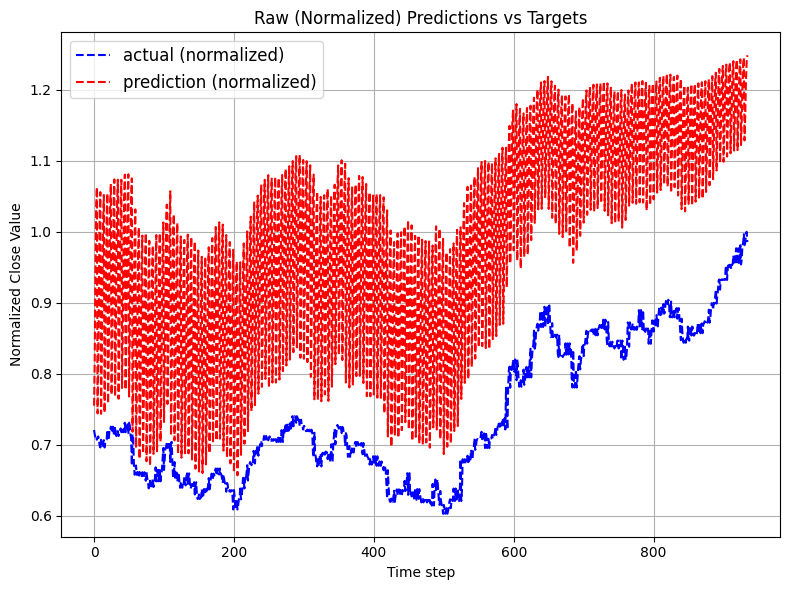

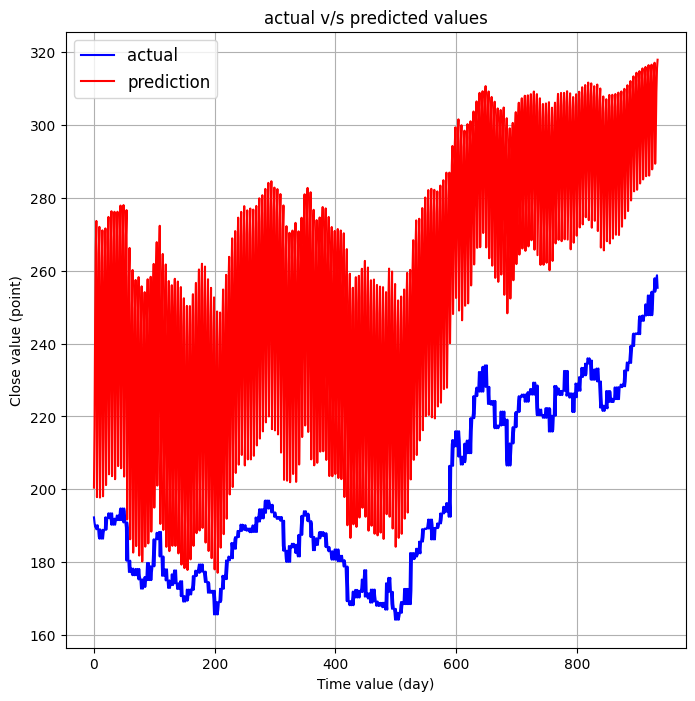

{'val_loss': 2.301158578638087,
 'val_mae': 0.24374234676361084,
 'val_accuracy': 0.0}

In [13]:
print("here!")
trainer.evaluate(val_loader)